In [305]:
import os
from pathlib import Path
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime

local_dataset_name = "ohlc_stock"
base_data_dir = Path("/home/jovyan/data")
dataset_specific_base_path = base_data_dir / local_dataset_name
raw_data_target_dir = dataset_specific_base_path / "raw"
os.makedirs(raw_data_target_dir, exist_ok=True)
print(f"Raw dataset directory: {raw_data_target_dir}")

# Tickers and FRED codes
stock_tickers = ["SPY", "NVDA", "BBAI", "UNH", "INTC", "BA", "GLD"]

sector_tickers = [                                  
    "XLY",  # Consumer Discretionary
    "XLP",  # Consumer Staples
    "XLE",  # Energy
    "XLF",  # Financials
    "XLV",  # Health Care
    "XLI",  # Industrials
    "XLB",  # Materials
    "XLK",  # Technology
    "XLU"   # Utilities
]
fred_symbols = {
    "federal_funds_rate": "FEDFUNDS",
    "unemployment_rate": "UNRATE",
    "cpi": "CPIAUCSL",
    "2y_treasury_yield": "DGS2",
    "10y_treasury_yield": "DGS10",
    "30y_treasury_yield": "DGS30",
    "m2_money_supply": "M2SL",
    "real_gdp": "GDPC1",
    "consumer_confidence_index": "UMCSENT",
    "gdp_nominal": "A191RP1Q027SBEA",
    "federal_surplus_deficit_pct_gdp": "FYFSGDA188S",
    "households_nonprofit_debt_securities_loans": "CMDEBT",
    "stock_market_cap_to_gdp": "DDDM01USA156NWDB",
    "bank_deposits_to_gdp": "DDOI02USA156NWDB",
    "federal_debt_pct_gdp": "GFDEGDQ188S",
    "personal_consumption_expenditures": "PCEC",
    "personal_savings_rate": "PSAVERT",
    "velocity_of_m2": "M2V",
    "consumer_loans_revolving_cclac": "CCLACBQ158SBOG",
    "consumer_loans_revolving_h8b": "H8B1247NCBCMG",
    "deposits_all_commercial_banks": "H8B1058NCBCMG",
}

start_date = "2000-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

def already_downloaded(ticker, directory):
    return (directory / f"{ticker}.csv").exists()

# Download stock OHLC data
for ticker in stock_tickers:
    target_file = raw_data_target_dir / f"{ticker}.csv"
    if already_downloaded(ticker, raw_data_target_dir):
        continue
    print(f"Downloading {ticker} OHLC from Yahoo Finance...")
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    df.to_csv(target_file)
    print(f"Saved {ticker} to {target_file}")

# ─── Download sector index data ─────────────────────────────────
for ticker in sector_tickers:
    target_file = raw_data_target_dir / f"{ticker}.csv"
    if already_downloaded(ticker, raw_data_target_dir):
        continue
    print(f"Downloading sector index {ticker} from Yahoo Finance...")
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    df.to_csv(target_file)
    print(f"Saved {ticker} to {target_file}")

# Download FRED macro features
for feature_name, fred_code in fred_symbols.items():
    target_file = raw_data_target_dir / f"{feature_name}.csv"
    if target_file.exists():
        continue
    print(f"Downloading {feature_name} ({fred_code}) from FRED...")
    df = pdr.DataReader(fred_code, 'fred', start_date, end_date)
    df.to_csv(target_file)
    print(f"Saved {feature_name} to {target_file}")

print("All data downloaded and stored in:", raw_data_target_dir)

# --- Cell 2: Import Libraries and Load Data ---

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import os
import cProfile # For basic profiling
import pstats # For processing profiling results
import io # For capturing profiling output
import gc
def reload_utils():
    import importlib
    import utils.etl
    import ohlc_stock.etl_chain
    import utils.eda
    import utils.eval
    import utils.submission
    import utils.models
    import utils.train

    importlib.reload(utils.etl)
    importlib.reload(ohlc_stock.etl_chain)
    importlib.reload(utils.eda)
    importlib.reload(utils.eval)
    importlib.reload(utils.train)
    importlib.reload(utils.models)
    importlib.reload(utils.submission)
    print("🔁 Reloaded ohlc_stock.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission")
# raw_data_target_dir = dataset_specific_base_path / "test"
# print(f"Listing files in {raw_data_target_dir}:")
try:
    for root, dirs, files in os.walk(raw_data_target_dir):
        level = root.replace(str(raw_data_target_dir), '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')
except FileNotFoundError:
    print(f"Error: Directory not found: {raw_data_target_dir}. Please ensure the dataset was downloaded and copied correctly.")
    # Exit or handle the error appropriately if the directory is not found

dfs = {}  # Store DataFrames by name
csv_files = list(raw_data_target_dir.glob("*.csv"))
for csv_file in csv_files:
    print(f"\n{'='*50}\nFile: {csv_file.name}")
    try:
        df = pd.read_csv(csv_file, parse_dates=True, index_col=0)
        dfs[csv_file.stem] = df
        print(f"Shape: {df.shape}")
        # Print date range
        if df.index.dtype == 'datetime64[ns]' or pd.api.types.is_datetime64_any_dtype(df.index):
            print(f"Date range: {df.index.min()} -> {df.index.max()}")
        else:
            print("Index is not datetime, sample index:", df.index[:5])       
    except Exception as e:
        print("Could not load file:", e)


Raw dataset directory: /home/jovyan/data/ohlc_stock/raw
All data downloaded and stored in: /home/jovyan/data/ohlc_stock/raw
raw/
    10y_treasury_yield.csv
    2y_treasury_yield.csv
    30y_treasury_yield.csv
    BA.csv
    bank_deposits_to_gdp.csv
    BBAI.csv
    consumer_confidence_index.csv
    consumer_loans_revolving_cclac.csv
    consumer_loans_revolving_h8b.csv
    cpi.csv
    deposits_all_commercial_banks.csv
    federal_debt_pct_gdp.csv
    federal_funds_rate.csv
    federal_surplus_deficit_pct_gdp.csv
    gdp_nominal.csv
    GLD.csv
    households_nonprofit_debt_securities_loans.csv
    INTC.csv
    m2_money_supply.csv
    merged_macro.parquet
    NVDA.csv
    personal_consumption_expenditures.csv
    personal_savings_rate.csv
    real_gdp.csv
    SPY.csv
    stock_market_cap_to_gdp.csv
    unemployment_rate.csv
    UNH.csv
    velocity_of_m2.csv
    XLB.csv
    XLE.csv
    XLF.csv
    XLI.csv
    XLK.csv
    XLP.csv
    XLU.csv
    XLV.csv
    XLY.csv

File: 10y_treasury_yi

/tmp/ipykernel_20830/1610137179.py:140: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_file, parse_dates=True, index_col=0)
/tmp/ipykernel_20830/1610137179.py:140: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_file, parse_dates=True, index_col=0)
/tmp/ipykernel_20830/1610137179.py:140: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_file, parse_dates=True, index_col=0)
/tmp/ipykernel_20830/1610137179.py:140: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`

Shape: (6391, 6)
Index is not datetime, sample index: Index(['Ticker', 'Date', '2000-01-03', '2000-01-04', '2000-01-05'], dtype='object', name='Price')

File: personal_consumption_expenditures.csv
Shape: (101, 1)
Date range: 2000-01-01 00:00:00 -> 2025-01-01 00:00:00

File: personal_savings_rate.csv
Shape: (303, 1)
Date range: 2000-01-01 00:00:00 -> 2025-03-01 00:00:00

File: real_gdp.csv
Shape: (101, 1)
Date range: 2000-01-01 00:00:00 -> 2025-01-01 00:00:00

File: SPY.csv
Shape: (6391, 6)
Index is not datetime, sample index: Index(['Ticker', 'Date', '2000-01-03', '2000-01-04', '2000-01-05'], dtype='object', name='Price')

File: stock_market_cap_to_gdp.csv
Shape: (21, 1)
Date range: 2000-01-01 00:00:00 -> 2020-01-01 00:00:00

File: unemployment_rate.csv
Shape: (304, 1)
Date range: 2000-01-01 00:00:00 -> 2025-04-01 00:00:00

File: UNH.csv
Shape: (6391, 6)
Index is not datetime, sample index: Index(['Ticker', 'Date', '2000-01-03', '2000-01-04', '2000-01-05'], dtype='object', name='Price'

/tmp/ipykernel_20830/1610137179.py:140: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_file, parse_dates=True, index_col=0)
/tmp/ipykernel_20830/1610137179.py:140: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_file, parse_dates=True, index_col=0)
/tmp/ipykernel_20830/1610137179.py:140: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_file, parse_dates=True, index_col=0)
/tmp/ipykernel_20830/1610137179.py:140: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`

In [306]:
import pandas as pd
from pathlib import Path

def robust_load_csv(csv_file):
    try:
        df = pd.read_csv(csv_file)
    except Exception as e:
        print(f"Could not read {csv_file}: {e}")
        return None
    # Find the date column
    possible_date_cols = [c for c in df.columns if c.lower() in ('date', 'datetime')]
    if possible_date_cols:
        date_col = possible_date_cols[0]
    else:
        date_col = df.columns[0]  # fallback
    mask = pd.to_datetime(df[date_col], errors='coerce').notnull()
    df = df.loc[mask]
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col)
    return df

# Paths & logic
TICKER = "INTC" # ["SPY", "NVDA", "BBAI", "UNH", "INTC", "BA", "GLD"]
ticker_dir = raw_data_target_dir / f"{TICKER}.csv"

# ─── get_build merged_macro ─────────────────────────────────────────
merged_macro_parquet_file = raw_data_target_dir / "merged_macro.parquet"
if not merged_macro_parquet_file.exists():
    macro_frames = []
    # Load FRED series
    for name in fred_symbols:
        file = raw_data_target_dir / f"{name}.csv"
        if not file.exists():
            print(f"{file} not found")
            continue
        df = pd.read_csv(file, parse_dates=True, index_col=0)
        df.columns = [name]
        macro_frames.append(df)
    
    # Load sector prices (Adj Close only)
    for ticker in sector_tickers:
        file = raw_data_target_dir / f"{ticker}.csv"
        if not file.exists():
            print(f"{file} not found")
            continue
        df = robust_load_csv(file)
        df = df[["Adj Close"]].rename(columns={"Adj Close": f"{ticker}_price"})

        macro_frames.append(df)
    
    # Concatenate all into merged_macro
    merged_macro = pd.concat(macro_frames, axis=1)
    print(merged_macro.columns)
    print(merged_macro.head)
    merged_macro.to_parquet(merged_macro_parquet_file)
    print(f"Saved merged_macro to {merged_macro_parquet_file}")
else:
    merged_macro = pd.read_parquet(merged_macro_parquet_file)

# ─── Merge with target TICKER  ────────────────────────
ticker = robust_load_csv(ticker_dir)

merged = merged_macro.join(ticker, how="outer")
print("Merged DataFrame ready with shape:", merged.shape)



Merged DataFrame ready with shape: (6716, 36)


/tmp/ipykernel_20830/1137145784.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mask = pd.to_datetime(df[date_col], errors='coerce').notnull()


In [307]:
import sys
sys.path.append(str(Path().resolve().parent))
reload_utils()
from utils.eval import display_system_memory_info
display_system_memory_info("System memory currently")

🔁 Reloaded ohlc_stock.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission

--- System memory currently ---
  System Total RAM:     15864.33 MB (15.49 GB)
  System Available RAM: 5369.74 MB (5.24 GB)
  System RAM Used (%):  66.2%
--------------------------------------


In [308]:
merged.columns

Index(['federal_funds_rate', 'unemployment_rate', 'cpi', '2y_treasury_yield',
       '10y_treasury_yield', '30y_treasury_yield', 'm2_money_supply',
       'real_gdp', 'consumer_confidence_index', 'gdp_nominal',
       'federal_surplus_deficit_pct_gdp',
       'households_nonprofit_debt_securities_loans', 'stock_market_cap_to_gdp',
       'bank_deposits_to_gdp', 'federal_debt_pct_gdp',
       'personal_consumption_expenditures', 'personal_savings_rate',
       'velocity_of_m2', 'consumer_loans_revolving_cclac',
       'consumer_loans_revolving_h8b', 'deposits_all_commercial_banks',
       'XLY_price', 'XLP_price', 'XLE_price', 'XLF_price', 'XLV_price',
       'XLI_price', 'XLB_price', 'XLK_price', 'XLU_price', 'Adj Close',
       'Close', 'High', 'Low', 'Open', 'Volume'],
      dtype='object')

In [309]:
# Assumption: normalized distribution of returns in next 30d
# Approach: Frequency vector per bin aggregated into histogram
# Loss function for prob vs prob: KL Divergence, Jensen-ShannonCross-Entropy, Earth Mover’s Distance, L2/L1
# y target: a vector of length num_bins e.g. [0.05, 0.10, 0.20, 0.40, 0.25] with bin0: >5%, bin1: 4-5%...
# updated y target: GMM cluster of above bins distribution

In [310]:
BIN_EDGES = [float('-inf'),-0.10,-0.08,-0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.0,
             0.01, 0.02, 0.03, 0.04, 0.05,0.06,0.08,0.10, float('inf')]
NUM_BINS = len(bin_edges) - 1
BIN_LABELS = [f'bin{i}' for i in range(num_bins)]
BIN_CENTERS = []
for i in range(len(bin_edges)-1):
    if np.isinf(bin_edges[i]):
        left = bin_edges[i+1] - 0.01
    else:
        left = bin_edges[i]
    if np.isinf(bin_edges[i+1]):
        right = bin_edges[i] + 0.01
    else:
        right = bin_edges[i+1]
    BIN_CENTERS.append(0.5 * (left + right))
OHLC_COLS = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

In [311]:
reload_utils()
from ohlc_stock.etl_chain import calc_y_target, get_macro_cols, engineer_macro_features, ffill_macro_columns
#processing
merged = ffill_macro_columns(merged, OHLC_COLS)

df, df_test = train_test_split(
    merged,
    test_size=0.2,
    shuffle=False,
    # random_state=42,
)

for col in OHLC_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce')
    
df = engineer_macro_features(df,OHLC_COLS)
df_test = engineer_macro_features(df_test, OHLC_COLS)

y_target_df = calc_y_target(df, price_col='Adj Close', bin_labels = BIN_LABELS, num_bins=NUM_BINS, horizon=30, bin_edges=BIN_EDGES)
y_target_df_test = calc_y_target(df_test, price_col='Adj Close', bin_labels = BIN_LABELS, num_bins=NUM_BINS, horizon=30, bin_edges=BIN_EDGES)

🔁 Reloaded ohlc_stock.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission


In [312]:
print(df.shape)
print(df_test.shape)
print(y_target_df.shape)
print(y_target_df_test.shape)


(5372, 216)
(1344, 216)
(5372, 18)
(1344, 18)


In [313]:
# df.describe()
# df.columns
# df.dtypes
# df.isna().sum()
# df.loc[df.duplicated()]
# df.duplicated().sum()
# 0 duplicated rows
# df.loc[df.duplicated(subset=['citric acid'])].head(5)
# df = df.loc[~df.duplicated(subset=['citric acid'])] \
#     .reset_index(drop=True).copy()
# df.shape
# df.head()
# df["HomePlanet"].unique()
# for col in df.columns:
#     print(col, df[col].dtype, df[col][0:3])


In [314]:
reload_utils()
from ohlc_stock.etl_chain import check_na_rows, df_progress_check
df_progress_check(df, df_test, y_target_df, y_target_df_test)

🔁 Reloaded ohlc_stock.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission
(5372, 216)
(5372, 18)
(1344, 216)
(1344, 18)
<class 'pandas.core.frame.DataFrame'>
🧮 4733/5372 rows would remain after -639 rows dropna (88.10%)
<class 'pandas.core.frame.DataFrame'>
🧮 5342/5372 rows would remain after -30 rows dropna (99.44%)
<class 'pandas.core.frame.DataFrame'>
🧮 1279/1344 rows would remain after -65 rows dropna (95.16%)
<class 'pandas.core.frame.DataFrame'>
🧮 1314/1344 rows would remain after -30 rows dropna (97.77%)


🔁 Reloaded ohlc_stock.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission


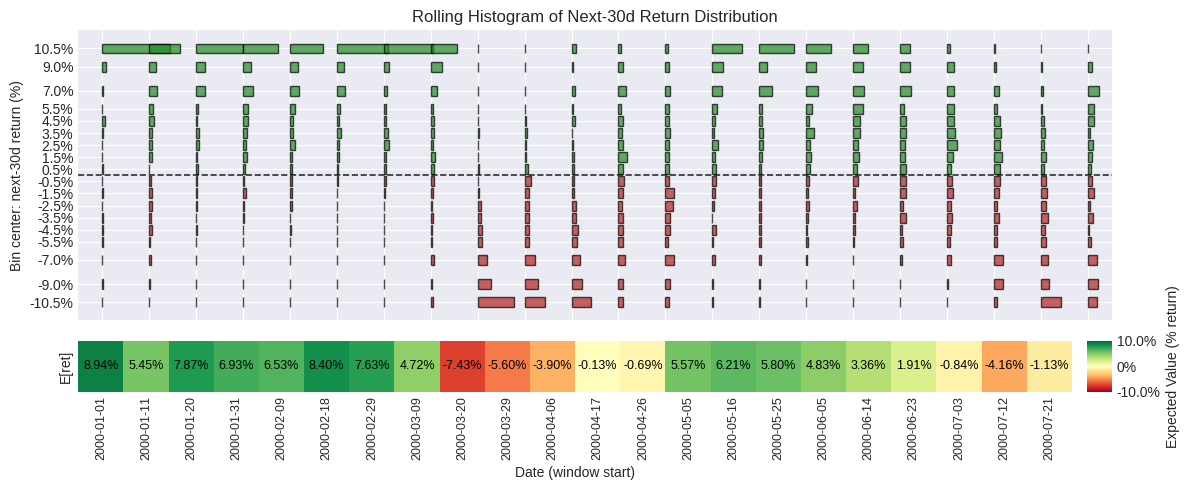

In [315]:
X_STEP = 7
FIRST_ROW_TO_GRAPH = 150

reload_utils()
from utils.eda import plot_y_bins_rolling_histogram

plot_y_bins_rolling_histogram(
    y_target_df=y_target_df,
    bin_edges=BIN_EDGES,
    bin_centers=BIN_CENTERS,
    window_step=X_STEP,
    first_n_rows=FIRST_ROW_TO_GRAPH,
)


In [316]:
reload_utils()
from ohlc_stock.etl_chain import add_lagged_target_moments

# X features see distribution of returns of 30d prior of last 30d, 40d prior of [-40, -10] trading days, and 50d
windows_to_calculate = [30, 45, 60] 

# add to X features the return distribution of 30d ahead of 30d prior, 45d prior, and 60d prior. no leakage
df = add_lagged_target_moments(
    main_df=df,
    y_target_df=y_target_df,
    centers_of_bins=BIN_CENTERS,
    window_sizes=windows_to_calculate
)
df_test = add_lagged_target_moments(
    main_df=df_test,
    y_target_df=y_target_df_test,
    centers_of_bins=BIN_CENTERS,
    window_sizes=windows_to_calculate
)

🔁 Reloaded ohlc_stock.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission

Adding lagged target moments for windows: [30, 45, 60]...


/home/jovyan/workspace/ohlc_stock/etl_chain.py:923: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skews.append(skew(samples))
/home/jovyan/workspace/ohlc_stock/etl_chain.py:924: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurts.append(kurtosis(samples))


  Joined features for window 30. New df shape: (5372, 220)


/home/jovyan/workspace/ohlc_stock/etl_chain.py:923: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skews.append(skew(samples))
/home/jovyan/workspace/ohlc_stock/etl_chain.py:924: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurts.append(kurtosis(samples))


  Joined features for window 45. New df shape: (5372, 224)


/home/jovyan/workspace/ohlc_stock/etl_chain.py:923: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skews.append(skew(samples))
/home/jovyan/workspace/ohlc_stock/etl_chain.py:924: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurts.append(kurtosis(samples))


  Joined features for window 60. New df shape: (5372, 228)

Adding lagged target moments for windows: [30, 45, 60]...


/home/jovyan/workspace/ohlc_stock/etl_chain.py:923: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skews.append(skew(samples))
/home/jovyan/workspace/ohlc_stock/etl_chain.py:924: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurts.append(kurtosis(samples))


  Joined features for window 30. New df shape: (1344, 220)


/home/jovyan/workspace/ohlc_stock/etl_chain.py:923: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skews.append(skew(samples))
/home/jovyan/workspace/ohlc_stock/etl_chain.py:924: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurts.append(kurtosis(samples))


  Joined features for window 45. New df shape: (1344, 224)


/home/jovyan/workspace/ohlc_stock/etl_chain.py:923: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skews.append(skew(samples))
/home/jovyan/workspace/ohlc_stock/etl_chain.py:924: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurts.append(kurtosis(samples))


  Joined features for window 60. New df shape: (1344, 228)


In [317]:
df_progress_check(df, df_test, y_target_df, y_target_df_test)

(5372, 228)
(5372, 18)
(1344, 228)
(1344, 18)
<class 'pandas.core.frame.DataFrame'>
🧮 4718/5372 rows would remain after -654 rows dropna (87.83%)
<class 'pandas.core.frame.DataFrame'>
🧮 5342/5372 rows would remain after -30 rows dropna (99.44%)
<class 'pandas.core.frame.DataFrame'>
🧮 1214/1344 rows would remain after -130 rows dropna (90.33%)
<class 'pandas.core.frame.DataFrame'>
🧮 1314/1344 rows would remain after -30 rows dropna (97.77%)


In [320]:
reload_utils()
from ohlc_stock.etl_chain import engineer_technical_indicators_relative

df = engineer_technical_indicators_relative(df)
df_test = engineer_technical_indicators_relative(df_test)

🔁 Reloaded ohlc_stock.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission
Debug: bb_mid_abs head (first 3): 
2000-01-01    24.710657
2000-01-03    24.710657
2000-01-04    24.326032
Name: Adj Close, dtype: float64
Debug: bb_std_abs head (first 3): 
2000-01-01    0.00000
2000-01-03    0.00000
2000-01-04    0.66619
Name: Adj Close, dtype: float64


TypeError: 'NoneType' object is not subscriptable

In [ ]:
df_progress_check(df, df_test, y_target_df, y_target_df_test)

In [ ]:
TASK_TYPE = "multinomial_classification"

raw_cols = [ 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] + list(fred_symbols.keys()) + sector_tickers
def is_raw_col(col):
    return (
        col in raw_cols
        # Exclude processed/engineered features by their typical suffixes:
        or (col.isupper() and not col.endswith('_ma'))
        or (col.endswith('_price'))
    )

In [ ]:
# keep only columns that are **not** absolute values aka raw/original macro/sector/price
X = df[[c for c in df.columns if not is_raw_col(c)]].copy()
X_test = df_test[[c for c in df_test.columns if not is_raw_col(c)]].copy()

price_test = df_test[['Adj Close']]
y=y_target_df

X_train, X_val, y_vectors_train, y_vectors_val = train_test_split(
    X,
    y, 
    test_size=0.2,
    shuffle=False, 
)

In [ ]:
########################################
#now we derive y_target from y bins of return distribution
########################################

In [ ]:
reload_utils()
from ohlc_stock.etl_chain import fit_gmm_on_train_transform_splits
N_CLUSTERS = 9

y_train_processed, y_val_processed, y_test_processed, fitted_gmm = fit_gmm_on_train_transform_splits(
    y_vectors_train,
    y_vectors_val,
    y_target_df_test,
    current_bin_edges=bin_edges, 
    current_bin_labels=bin_labels, 
    n_clusters=N_CLUSTERS
)

y_train = y_train_processed[["Cluster_Assignment"]]
y_val = y_val_processed[["Cluster_Assignment"]]
y_test = y_test_processed[["Cluster_Assignment"]]
y_train_df_with_ev = y_train_processed[["Cluster_Assignment", "EV"]]
print("y_train shape:", y_train.shape, "| Unique clusters:", y_train['Cluster_Assignment'].nunique())
print("\ny_val shape:", y_val.shape, "| Unique clusters:", y_val['Cluster_Assignment'].nunique())
print("\ny_test shape:", y_test.shape, "| Unique clusters:", y_test['Cluster_Assignment'].nunique())



In [ ]:
y_train_df_with_ev = y_train_processed[["Cluster_Assignment", "EV"]]
y_val_df_with_ev = y_val_processed[["Cluster_Assignment", "EV"]]
y_test_df_with_ev = y_test_processed[["Cluster_Assignment", "EV"]]


In [ ]:
df_progress_check(df, df_test, y_target_df, y_target_df_test)

In [ ]:
reload_utils()
from utils.eda import analyze_cluster_ev_category_shifts, plot_ev_by_cluster_scatter, plot_mean_ev_category_shift_comparison

ev_categories_dict = {
        'deep_loss_upper': -0.03,  # EV < -0.03 is Deep Loss
        'loss_upper': -0.005,     # -0.03 <= EV < -0.005 is Loss
        'neutral_upper': 0.005,   # -0.005 <= EV <= 0.005 is Neutral
        'profit_upper': 0.03,     # 0.005 < EV <= 0.03 is Profit
                                  # EV > 0.03 is Deep Profit
    }

hypothesis_df = analyze_cluster_ev_category_shifts(y_train_processed, y_val_processed, ev_categories_dict)
plot_mean_ev_category_shift_comparison(hypothesis_df, chart_title = "Train vs Val clusters")
hypothesis_df_test = analyze_cluster_ev_category_shifts(y_train_processed, y_test_processed, ev_categories_dict)
plot_mean_ev_category_shift_comparison(hypothesis_df_test, chart_title = "Train vs Test clusters")

plot_ev_by_cluster_scatter(y_train_processed, chart_title = "Clusters Distribution in y_train")
plot_ev_by_cluster_scatter(y_val_processed, chart_title = "Clusters Distribution in y_val")
plot_ev_by_cluster_scatter(y_test_processed, chart_title = "Clusters Distribution in y_test")

In [ ]:
reload_utils()
from utils.eval import metric_lookup
perf_eval_metric = "accuracy"  
eval_metric_name, eval_metric_fn = metric_lookup[perf_eval_metric]
print(f"✅ Evaluation metric set to: {eval_metric_name}")

In [ ]:
# === Domain knowledge ===
# Any semantic/description of features?
# Ft1 - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.


In [ ]:
# from utils.eda import eda_vis
# # === prelim EDA on raw dataset ===
# eda_vis(X, y, task_type)
# reload_utils()
# from utils.eda import feature_eda_vis
# === deep EDA for features on ETL-applied dataset ===
# feature_eda_vis(X_train, y_train_processed, task_type)

In [ ]:
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)
X_test = pd.DataFrame(X_test)
price_test = pd.DataFrame(price_test)

# Make sure y values are Series (not affected by dropna on X)
y_train = y_train.squeeze()
y_val = y_val.squeeze()
y_test = y_test.squeeze()

# --- Drop NaNs and align ---
X_train_clean = X_train.dropna()
y_train_clean = y_train.loc[X_train_clean.index]

X_val_clean = X_val.dropna()
y_val_clean = y_val.loc[X_val_clean.index]

X_test_clean = X_test.dropna()
y_test_clean = y_test.loc[X_test_clean.index]
price_test_clean = price_test.loc[X_test_clean.index] 

X_train, y_train = X_train_clean, y_train_clean
X_val, y_val = X_val_clean, y_val_clean
X_test, y_test = X_test_clean, y_test_clean
price_test = price_test_clean

In [ ]:
reload_utils()
# check_na_rows(y_train)
# check_na_rows(y_val)
# check_na_rows(y_test)
check_na_rows(X_train)
print(len(y_train))
check_na_rows(X_val)
check_na_rows(X_test)



In [ ]:
#### EDA on X_train x y_train ####
reload_utils()
from utils.eda import eda_vis, eda_feature_transformation_check, feature_eda_vis
# eda_vis(X_train, y_train, task_type)
# eda_feature_transformation_check(X_train, y_train, task_type) #check for recommended scaling, clipping, dropping
# feature_eda_vis(X_train, y_train, task_type) #3 charts per feature
# eda_vis_v2(X_train, y_train)

In [ ]:
################DEMO RUN####################

In [ ]:
reload_utils()
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from utils.train import train_sklearn_model, train_nn_model, log_model_artifact, log_final_metrics
from utils.eval import  evaluate_model
from utils.models import get_nn_model, get_sklearn_model
from xgboost import XGBClassifier, XGBRegressor

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

# --- 1. Random Forest Regressor (multioutput)
rf_params = {"n_estimators": 42, "max_depth": 5, "max_features": 'sqrt',
            "min_samples_split": 5,}
rf_model = get_sklearn_model("random_forest", task_type = task_type, **rf_params)
trained_rf, y_pred_rf, y_pred_proba_rf = train_sklearn_model(rf_model, X_train, y_train, 
                                                             X_val, y_val, task_type=task_type,)
print("Random Forest y_pred_rf shape:", y_pred_rf.shape)
print("Random Forest y_pred_proba_rf shape:", y_pred_proba_rf.shape)

# --- 2. XGBoost Regressor (multioutput)
xgb_params = {"n_estimators": 42, "max_depth": 5, "learning_rate": 0.005,
            "subsample": .8, "colsample_bytree": .8,}
xgb_model = get_sklearn_model("xgboost", task_type = task_type, **xgb_params)
trained_xgb, y_pred_xgb, y_pred_proba_xgb = train_sklearn_model(xgb_model, X_train, y_train, 
                                                                X_val, y_val, task_type=task_type,)
print("XGBoost y_pred_xgb shape:", y_pred_xgb.shape)
print("XGBoost y_pred_proba_xgb shape:", y_pred_proba_xgb.shape)

# --- 3. Neural Network Model(s)
nn_params = {"model_type": "mlp", "hidden": 42, "dropout": 0.3,
            "activation": "relu", "batch_norm": True, "lr": 0.05, "num_layers": 1 }
output_dim = y_train.nunique() if task_type == "multinomial_classification" else 1
if hasattr(output_dim, '__len__'): 
    output_dim = output_dim.sum()   
model, lr = get_nn_model(X_train.shape[1], output_dim=output_dim, **nn_params)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_val_nn = scaler.transform(X_val)
X_test_nn =  scaler.transform(X_test)
trained_nn, y_pred_nn, y_pred_proba_nn, y_preds_per_epoch_list = train_nn_model(
    model, X_train_nn, y_train, X_val_nn, y_val,
    epochs=20,
    lr=lr,
    task_type=task_type,
    eval_metric_name=eval_metric_name,
    eval_metric_fn=eval_metric_fn,
)
y_pred_nn = y_pred_nn.reshape(-1, 1)
print("✅ Finished training neural net")
print("NN y_pred_nn shape:", y_pred_nn.shape)
print("NN y_pred_proba_nn shape:", y_pred_proba_nn.shape)


print("Ready for evaluation.")


In [ ]:
print(type(y_pred_xgb))
print(type(y_pred_proba_xgb))
print(y_pred_xgb.shape)
print(type(y_pred_rf))
print(type(y_pred_proba_rf))
print(y_pred_rf.shape)
print(type(y_pred_nn))
print(type(y_pred_proba_nn))
print(y_pred_nn.shape)

print(type(y_val))

In [ ]:
# print(y_pred_xgb)
# print(y_pred_nn )
print(np.max(X_train_nn), np.min(X_train_nn), np.mean(X_train_nn))
print(np.isnan(X_train).sum().sum(), np.isinf(X_train).sum().sum())

In [ ]:
reload_utils()
from utils.eval import get_ev_category, get_cluster_ev_mapping, evaluate_model_predictions


In [ ]:
predictions_dict = {
    'XGBoost': y_pred_xgb,
    'Random Forest': y_pred_rf,
    'Neural Network': y_pred_nn,
}

# Only include probabilities if they are available and correctly formatted
probabilities_dict = {}
if 'y_pred_proba_xgb' in locals() and isinstance(y_pred_proba_xgb, np.ndarray):
    probabilities_dict['XGBoost'] = y_pred_proba_xgb
if 'y_pred_proba_rf' in locals() and isinstance(y_pred_proba_rf, np.ndarray):
    probabilities_dict['Random Forest'] = y_pred_proba_rf
if 'y_pred_proba_nn' in locals() and isinstance(y_pred_proba_nn, np.ndarray):
    probabilities_dict['Neural Network'] = y_pred_proba_nn

y_val = pd.DataFrame(y_val)
# y_train_df_with_ev
# y_val_df_with_ev
# y_test_df_with_ev
evaluate_model_predictions(
    y_true_df=y_val,
    y_pred_dict=predictions_dict,
    y_target_df_with_ev=y_val_df_with_ev,
    y_pred_proba_dict=probabilities_dict
)

In [ ]:
print("verifying test partition before .pred on test")
print(X_test.shape)
print(price_test.shape)
check_na_rows(X_test)

In [ ]:
# To evaluate test partition results, first get statistics of each cluster
cluster_mean_ev_mapping = get_cluster_ev_mapping(y_train_processed, agg_func='mean')
cluster_median_ev_mapping = get_cluster_ev_mapping(y_train_processed, agg_func='median')

##### Getting Y_PRED for TEST SET #####
y_pred_test_xgb = trained_xgb.predict(X_test)
y_pred_test_rf = trained_rf.predict(X_test)

y_pred_proba_test_xgb = trained_xgb.predict_proba(X_test)
y_pred_proba_test_rf = trained_rf.predict_proba(X_test)

import torch
import torch.nn.functional as F
trained_nn.eval()  
X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    logits = trained_nn(X_test_tensor)
    y_pred_test_nn = torch.argmax(logits, dim=1).cpu().numpy()  # Predicted labels
    y_pred_proba_test_nn = F.softmax(logits, dim=1).cpu().numpy()  # Predicted probabilities
##### Getting Y_PRED for TEST SET #####

In [ ]:
reload_utils()
from utils.eval import run_trading_simulation, plot_trading_actions

In [ ]:
initial_portfolio_value = 100000.0
trade_size = 3000.0
hold_apr = 0.05
ev_profit_threshold = 0.005
position_hold_days = 30
periods_per_year = 252 

model_classes_ordered = list(trained_xgb.classes_) #or trained_rf or trained_nn works too

if 'price_test' in locals() and isinstance(price_test, pd.DataFrame) and 'Adj Close' in price_test.columns:
    price_test_series = price_test['Adj Close']
elif 'price_test' in locals() and isinstance(price_test, pd.Series):
    price_test_series = price_test
else:
    print("check on price_test_series or  price_test")


In [ ]:
print("\n--- Running Trading Simulation for Neural Network Model ---")
portfolio_df_nn, metrics_nn, all_trade_actions_nn = run_trading_simulation(
    price_test_series=price_test_series,
    y_pred_proba_test=y_pred_proba_test_nn,
    cluster_mean_ev_mapping=cluster_mean_ev_mapping,
    model_classes_ordered=model_classes_ordered, 
    initial_portfolio_value=initial_portfolio_value,
    trade_size=trade_size,
    hold_apr=hold_apr,
    ev_profit_threshold=ev_profit_threshold,
    position_hold_days=position_hold_days,
    model_name="Neural Net Strategy",
    periods_per_year=periods_per_year)
    
print("\n--- Running Simulation for XGBoost Model ---")
portfolio_df_xgb, metrics_xgb, all_trade_actions_xgb = run_trading_simulation(
    price_test_series=price_test_series,
    y_pred_proba_test=y_pred_proba_test_xgb,
    cluster_mean_ev_mapping=cluster_mean_ev_mapping,
    model_classes_ordered=model_classes_ordered,
    initial_portfolio_value=initial_portfolio_value,
    trade_size=trade_size,
    hold_apr=hold_apr,
    ev_profit_threshold=ev_profit_threshold,
    position_hold_days=position_hold_days,
    model_name="XGBoost Strategy",
    periods_per_year=periods_per_year)

print("\n--- Running Simulation for Random Forest Model ---")
portfolio_df_rf, metrics_rf, all_trade_actions_rf = run_trading_simulation(
    price_test_series=price_test_series,
    y_pred_proba_test=y_pred_proba_test_rf,
    cluster_mean_ev_mapping=cluster_mean_ev_mapping,
    model_classes_ordered=model_classes_ordered,
    initial_portfolio_value=initial_portfolio_value,
    trade_size=trade_size,
    hold_apr=hold_apr,
    ev_profit_threshold=ev_profit_threshold,
    position_hold_days=position_hold_days,
    model_name="Random Forest Strategy",
    periods_per_year=periods_per_year)

In [ ]:

reload_utils()
from utils.eval import visualize_strategy_kpis_versus_benchmarks
    
model_data_pairs = [
    ("Neural Network Model Results", metrics_nn, all_trade_actions_nn),
    ("XGBoost Model Results", metrics_xgb, all_trade_actions_xgb),
    ("Random Forest Model Results", metrics_rf, all_trade_actions_rf),]

ROLLING_WINDOW_DAYS_PARAM = 62 
last_n_days_to_plot = 90
benchmark_apr_target_value = hold_apr 
num_days_in_series = len(price_test_series)
num_years_in_series = 0

if periods_per_year > 0 and num_days_in_series > 0:
    num_years_in_series = num_days_in_series / periods_per_year
else:
    print("Warning: periods_per_year or num_days_in_series is not valid for APR calculation. APR might be N/A.")
    num_years_in_series = 1.0 # Default, makes APR less meaningful if true period is 0


# --- Main Evaluation Loop ---
for model_display_name, metrics_dict, actions_dict in model_data_pairs:
    if not isinstance(metrics_dict, dict) or not isinstance(actions_dict, dict):
        print(f"\nSkipping data for {model_display_name} due to incorrect data types.")
        continue

    benchmark_strategy_key = 'Hold Benchmark' 
    benchmark_metrics = metrics_dict.get(benchmark_strategy_key, {})
    print(f"\n\n{'='*70}")
    print(f"📊 EVALUATING MODEL: {model_display_name}")
    print(f"{'='*70}")
    print(f"\n--- Overall Model Benchmark Reference (from '{benchmark_strategy_key}') ---")
    print(f"Target APR (based on input 'hold_apr'): {benchmark_apr_target_value*100:.2f}%")
    print("-" * 70)
    for strategy_name, trade_actions_list in actions_dict.items():
        if strategy_name == benchmark_strategy_key:
            continue
        strategy_specific_metrics = metrics_dict.get(strategy_name)
        if not strategy_specific_metrics:
            print(f"\nMetrics not found for strategy: '{strategy_name}' in {model_display_name}. Skipping.")
            continue

        print(f"\n\n--- Strategy: {strategy_name} ---")
        total_return_val = strategy_specific_metrics.get('Total Return (%)', np.nan)
        strategy_apr_pct_val = np.nan
        if num_years_in_series > 0 and not pd.isna(total_return_val) and total_return_val > -100:
            base_for_apr_calc = 1 + total_return_val / 100
            if base_for_apr_calc > 1e-9:
                strategy_apr_pct_val = (base_for_apr_calc**(1 / num_years_in_series) - 1) * 100
        
        strategy_specific_metrics['Calculated APR (%)'] = strategy_apr_pct_val

        visualize_strategy_kpis_versus_benchmarks(
            strategy_name=strategy_name,
            strategy_metrics=strategy_specific_metrics, 
            target_apr_pct_value=benchmark_apr_target_value,
            model_context_name=model_display_name,
            rolling_window_days=ROLLING_WINDOW_DAYS_PARAM 
        )

        strategy_sharpe_val = strategy_specific_metrics.get('Sharpe Ratio (Annualized)', np.nan)
        print(f"  Additional Stats:")
        if not pd.isna(total_return_val):
            print(f"    📈 Total Return: {total_return_val:.2f}%")
        else:
            print(f"    📈 Total Return: N/A")

        if 'Total Trades' in strategy_specific_metrics:
            print(f"    Trades: {strategy_specific_metrics['Total Trades']}")
            print(f"    Wins: {strategy_specific_metrics.get('Win Rate (%)', 0.0):.2f}%")
        else:
            print(f"    Trades: N/A")
        
        ###### Plotting Trade Actions ######
        print(f"\n  Visualizing Trade Actions for: {strategy_name}...")
        if not isinstance(trade_actions_list, list):
            print(f"    Warning: Trade actions for '{strategy_name}' is not a list. Skipping plot.")
            continue
        
        plot_trading_actions(
            price_series=price_test_series,
            trade_actions=trade_actions_list,
            strategy_name=strategy_name,
            last_n_days=last_n_days_to_plot
        )
        print("-" * 50)

In [ ]:
reload_utils()

from utils.eval import evaluate_trading
import re

def sanitize_metric_key(key):
    # Replace anything not allowed by MLflow with underscore
    return re.sub(r"[^\w\s\-.:/]", "", key) 

ALLOWED_TRADING_METRIC_KEYS = [
    "Win Rate",
    "Buy Wins",
    "Short Wins",
    "Total Return",
    "Total Trades",
    "Sharpe Ratio"
]
BASELINE_STRATEGIES = ["Perfect Foresight", "Hold Benchmark"]
NUM_EPOCH = 80


In [ ]:
from utils.models import get_sklearn_model, get_nn_model
from utils.train import train_sklearn_model, train_nn_model, log_model_artifact, log_final_metrics, \
                        conditionally_encode_labels
from utils.eval import evaluate_model
import mlflow
os.environ["WANDB_BASE_URL"] = "http://wandb:8080"
os.environ["WANDB_DEBUG"] = "true"
os.environ["WANDB_DEBUG_LOG_PATH"] = "/tmp/wandb_debug.log"
import wandb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define model sweep
print("defining sweep")
# model_configs = {
#     "decision_tree": [
#         {"criterion": "gini", "max_depth": 5, "min_samples_split": 2, "min_samples_leaf": 1}
#     ],

#     "random_forest": [
#         {"n_estimators": 200, "max_depth": 10, "max_features": "sqrt", "min_samples_split": 2}
#     ],

#     "logistic_regression": [
#         {"penalty": "l2", "C": 1.0, "solver": "liblinear", "max_iter": 200}
#     ],

#     "xgboost": [
#         {"n_estimators": 200, "max_depth": 5, "learning_rate": 0.1, "subsample": 1.0, "colsample_bytree": 1.0}
#     ],

#     "lightgbm": [
#         {"n_estimators": 100, "max_depth": -1, "learning_rate": 0.1, "num_leaves": 31, "min_child_samples": 20}
#     ],

#     "naive_bayes": [
#         {"var_smoothing": 1e-9}
#     ],

#     "knn": [
#         {"n_neighbors": 5, "weights": "uniform", "metric": "euclidean"}
#     ],

#     "neural_net": [
#         {
#             "model_type": "mlp",
#             "hidden": 64,
#             "dropout": 0.3,
#             "activation": "relu",
#             "batch_norm": True,
#             "lr": 0.001,
#             "num_layers": 2
#         }
#     ],
# }

model_configs = {
    # "decision_tree": [
    #     {"criterion": c, "max_depth": d, "min_samples_split": m, "min_samples_leaf": l}
    #     for c in ["gini", "entropy"]
    #     for d in [None, 5, 10]
    #     for m in [2, 5]
    #     for l in [1, 2]
    # ],

    # "random_forest": [
    #     {"n_estimators": n, "max_depth": d, "max_features": f, "min_samples_split": m}
    #     for n in [50, 200, 400]
    #     for d in [None, 10,15]
    #     for f in ["sqrt", "log2"]
    #     for m in [2, 5]
    # ],

    # "logistic_regression": [
    #     {"penalty": p, "C": c, "solver": "liblinear", "max_iter": 200}
    #     for p in ["l1", "l2"]
    #     for c in [0.01, 0.1, 1.0]
    # ],

    # "xgboost": [
    #     {"n_estimators": n, "max_depth": d, "learning_rate": lr, "subsample": s, "colsample_bytree": cbt}
    #     for n in [200,400]
    #     for d in [5, 7]
    #     for lr in [0.005, 0.1]
    #     for s in [0.8, 1.0]
    #     for cbt in [0.8, 1.0]
    # ],

    # "lightgbm": [
    #     {"n_estimators": n, "max_depth": d, "learning_rate": lr, "num_leaves": nl, "min_child_samples": mcs}
    #     for n in [100, 200]
    #     for d in [-1, 10]
    #     for lr in [0.01, 0.1]
    #     for nl in [31, 50]
    #     for mcs in [10, 20]
    # ],
    

    # "naive_bayes": [
    #     {"var_smoothing": vs}
    #     for vs in [1e-9, 1e-8, 1e-7]
    # ],

    # "knn": [
    #     {"n_neighbors": k, "weights": w, "metric": m}
    #     for k in [ 5, 7]
    #     for w in ["uniform", "distance"]
    #     for m in ["euclidean", "manhattan"]
    # ],
    "neural_net": [
        {
            "model_type": mt,
            "hidden": h,
            "dropout": d,
            "activation": act,
            "batch_norm": bn,
            "lr": lr,
            "num_layers": nl
        }
        for mt in ["mlp", #"lstm", 
                   #"cnn"
                  ]
        for h in [#32, 64,128,256,569, 
                1024, 2048]
        for d in [#0.0, 
                  0.3]
        for act in ["relu", 
                    #"tanh"
                   ]
        for bn in [#False, 
                True]
        for lr in [.0001, .00005
                   #.005, 0.001, .05, 0.01, .5
                  ]
        for nl in [#1, 
                   #2, 3,4,
                   #5, 8,
                    16,21]
    ],
}

mlflow.set_experiment(f"{TICKER}_{end_date}")
print("starting experiments")
# Loop over each model and its hyperparam
for model_name, config_list in model_configs.items():
    for params in config_list:
        # Terminate any already running experiments (MLflow and W&B)
        if mlflow.active_run() is not None:
            mlflow.end_run()
        wandb.finish()
        # === Init Experiment | MLflow and W&B ===
        run_name = f"{model_name}_{end_date}_{params}"
        run = mlflow.start_run(run_name=run_name)
        mlflow.log_param("model_name", model_name)
        mlflow.log_params(params)
        mlflow.log_param("task_type", task_type)
        mlflow.log_param("perf_eval_metric", perf_eval_metric)
        # mlflow.log_param("etl_version", etl_result['etl_version'])
        # mlflow.log_param("etl_description", etl_result['etl_description'])
        print("Started MLflow run:", run.info.run_id)
        wandb.init(
            project=f"local_{local_dataset_name}",
            name=run_name,
            config={
                **params,
                "model_name": model_name,
                "task_type": task_type,
                "perf_eval_metric": perf_eval_metric,
                # "etl_version": etl_result['etl_version'],
                # "etl_description": etl_result['etl_description']
            }
        )
        # === Train ===
        if model_name == "neural_net":
            output_dim = y_train.nunique() if task_type == "multinomial_classification" else 1
            if hasattr(output_dim, '__len__'):  
                output_dim = output_dim.sum()   
            model, lr = get_nn_model(X_train.shape[1], output_dim=output_dim, **params)
            trained_nn, y_pred_nn, y_pred_proba_nn, y_preds_per_epoch_list = train_nn_model(
                model, X_train_nn, y_train, X_val_nn, y_val,
                epochs=NUM_EPOCH, #max epoch
                lr=lr,
                task_type=task_type,
                eval_metric_name=eval_metric_name,
                eval_metric_fn=eval_metric_fn,
            )
            y_pred = y_pred_nn.reshape(-1, 1)
            print("✅ Finished training neural net")
            trained_nn.eval()  
            with torch.no_grad():
                logits = trained_nn(X_test_tensor)
                # y_pred_test = torch.argmax(logits, dim=1).cpu().numpy()  # Predicted labels
                y_pred_proba_test = F.softmax(logits, dim=1).cpu().numpy()  # Predicted probabilities

        else:
            model = get_sklearn_model(model_name, task_type = task_type, **params)
            trained_model, y_pred, y_pred_proba = train_sklearn_model(
                model, X_train, y_train, X_val, y_val,
                task_type=task_type,
            )
            y_pred_proba_test = trained_model.predict_proba(X_test)
            print("✅ Finished training sklearn model")

        # === Evaluate & log ===
        eval_metrics = evaluate_model(y_val, y_pred, task_type)

        trading_results = evaluate_trading(
            y_pred_proba_test=y_pred_proba_test,  
            price_test_series=price_test_series,
            cluster_mean_ev_mapping=cluster_mean_ev_mapping,
            model_classes_ordered=model_classes_ordered_rf,
            model_name=model_name,
            initial_portfolio_value=initial_portfolio_value,
            trade_size=trade_size,
            hold_apr=hold_apr,
            ev_profit_threshold=ev_profit_threshold,
            position_hold_days=position_hold_days,
            periods_per_year=periods_per_year
        )
        if "trading_metrics" in trading_results:
            for model_name_of_metrics, metrics_dict in trading_results["trading_metrics"].items():
                # Skip if baseline strategy
                if any(baseline in model_name_of_metrics for baseline in BASELINE_STRATEGIES):
                    continue
        
                for k, v in metrics_dict.items():
                    if isinstance(v, list):
                        continue  # skip rolling windows, etc.
        
                    # Match allowed metrics only
                    if any(k.strip().startswith(allowed) for allowed in ALLOWED_TRADING_METRIC_KEYS):
                        # full_key = f"{model_name_of_metrics.split()[-1]}.{k.replace(" ", "_")}"
                        full_key = f"{model_name_of_metrics.split()[-1]}.{k.replace(' ', '_')}"
                        wandb.log({
                            f"{model_name_of_metrics.split()[-1]}/{k}": v
                        })
                        sanitized_key = sanitize_metric_key(full_key)
                        eval_metrics[sanitized_key] = v
        log_final_metrics(eval_metrics)
        # === End Experiment | MLflow and W&B ===
        mlflow.end_run()
        wandb.finish()


In [ ]:
#verify all is good for X_train, y_train, X_test, price_test for test set eval
# df_progress_check(X_train_nn, y_train, X_test_nn, price_test_series)

🔁 Reloaded ohlc_stock.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission
Using device: cuda
Epoch 1/80 => Train Loss: 2.1769, Val Score (accuracy): 0.2405
    New best validation score: 0.2405
Epoch 2/80 => Train Loss: 2.1456, Val Score (accuracy): 0.2565
    New best validation score: 0.2565
Epoch 3/80 => Train Loss: 2.1151, Val Score (accuracy): 0.2635
    New best validation score: 0.2635
Epoch 4/80 => Train Loss: 2.0838, Val Score (accuracy): 0.2715
    New best validation score: 0.2715
Epoch 5/80 => Train Loss: 2.0515, Val Score (accuracy): 0.2864
    New best validation score: 0.2864
Epoch 6/80 => Train Loss: 2.0178, Val Score (accuracy): 0.2914
    New best validation score: 0.2914
Epoch 7/80 => Train Loss: 1.9838, Val Score (accuracy): 0.2764
Epoch 8/80 => Train Loss: 1.9514, Val Score (accuracy): 0.2824
Epoch 9/80 => Train Loss: 1.9217, Val Score (accuracy): 0.2854
Epoch 10/80 => Train Loss: 1.8948, Val Score (accuracy): 0.2964
    New best validation score: 0.2964


/home/jovyan/workspace/utils/eval.py:1540: RuntimeWarning: Mean of empty slice




📊 EVALUATING MODEL: Neural Network Model Results


--- Strategy: Neural Net Strategy (Top-1) ---


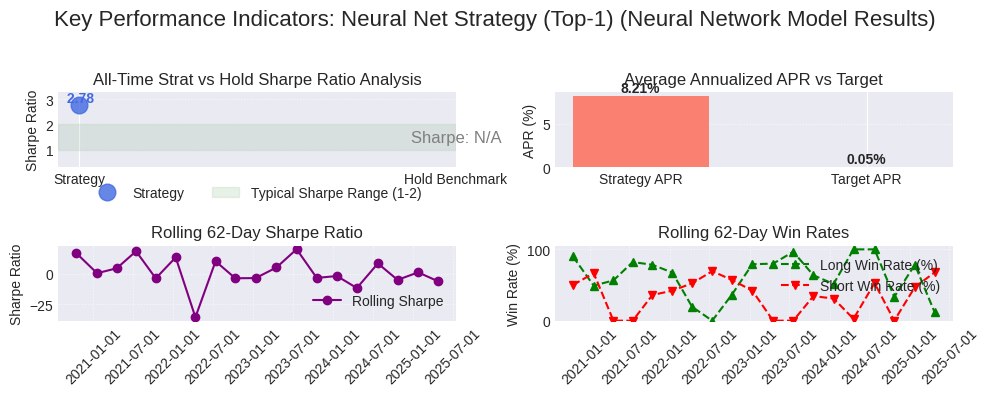

  Additional Stats:
    📈 Total Return: 45.52%
    Trades: 1168
    Wins: 55.05%


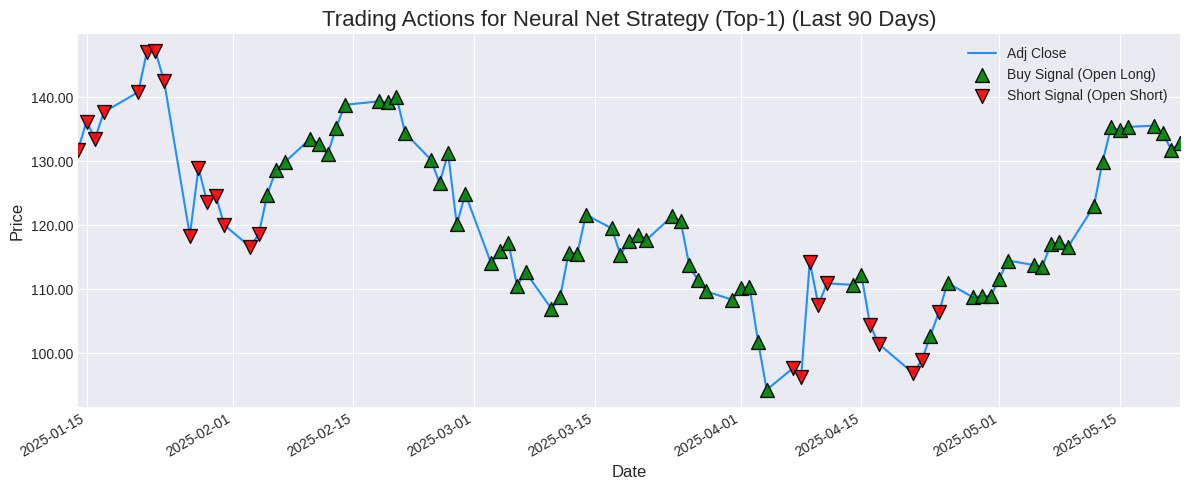

---------------------------------------------------------------------


--- Strategy: Neural Net Strategy (Top-2 Consensus) ---


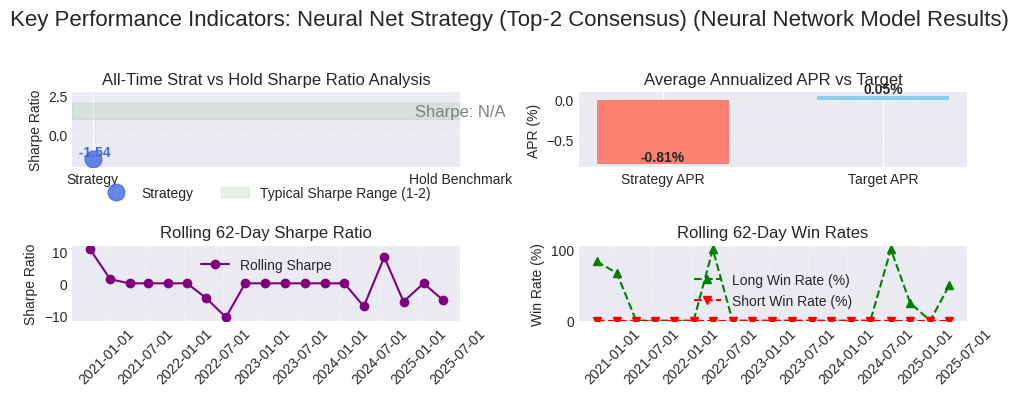

  Additional Stats:
    📈 Total Return: -3.81%
    Trades: 47
    Wins: 46.81%


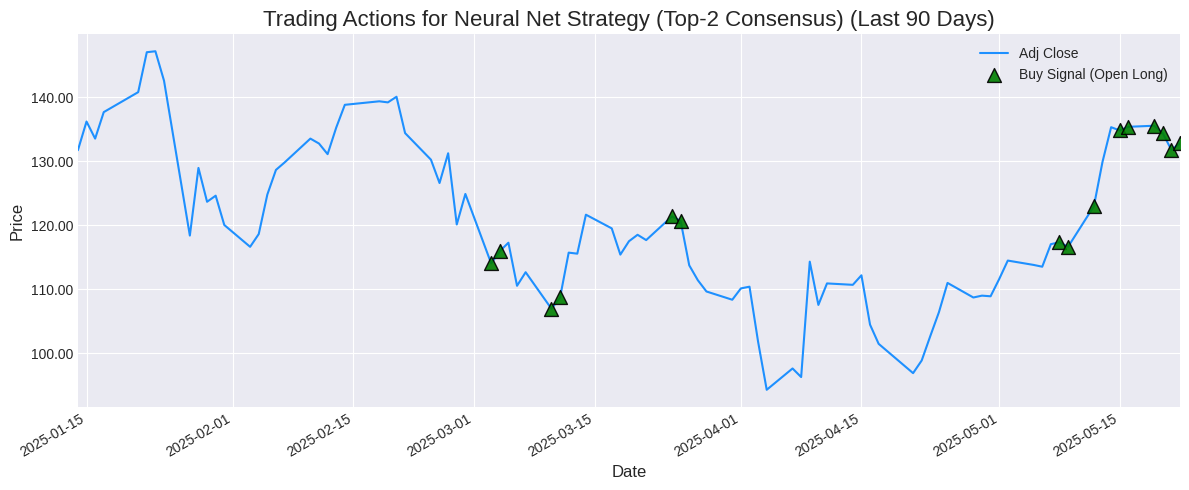

---------------------------------------------------------------------


--- Strategy: Neural Net Strategy (Cum@90) ---


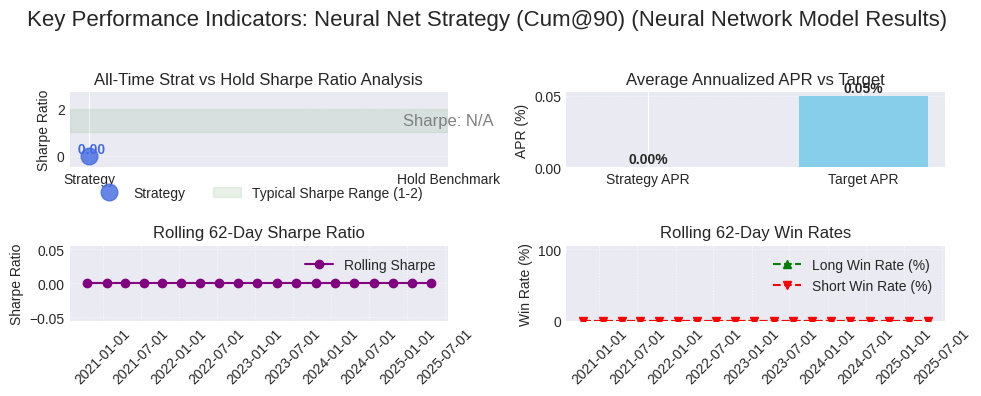

  Additional Stats:
    📈 Total Return: 0.00%
    Trades: 0
    Wins: 0.00%


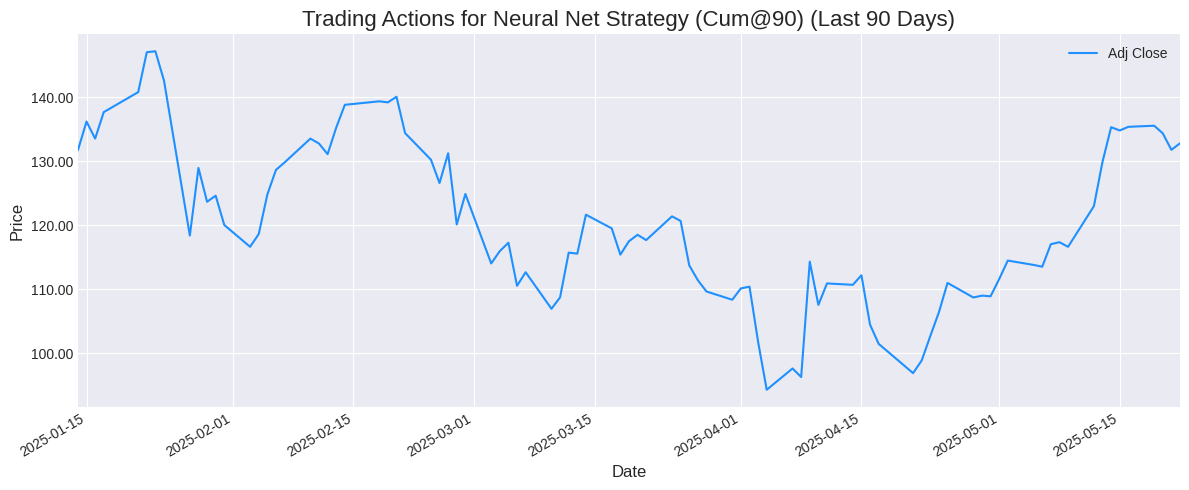

---------------------------------------------------------------------


--- Strategy: Neural Net Strategy (Cum@75) ---


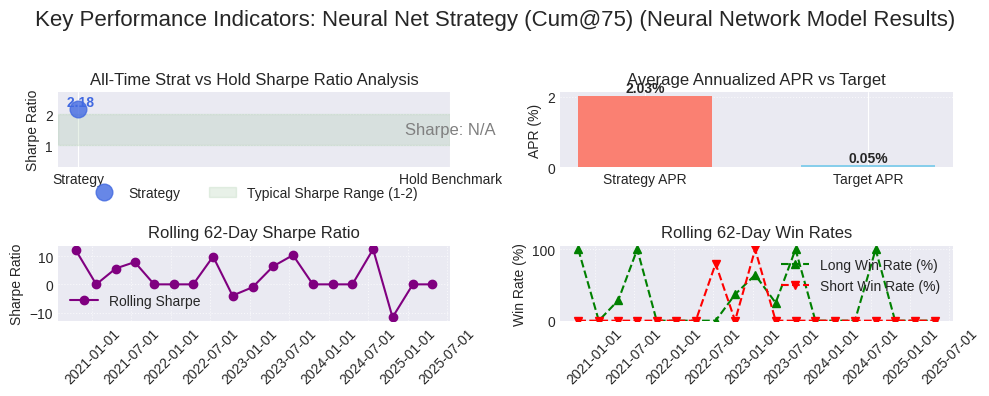

  Additional Stats:
    📈 Total Return: 10.02%
    Trades: 95
    Wins: 63.16%


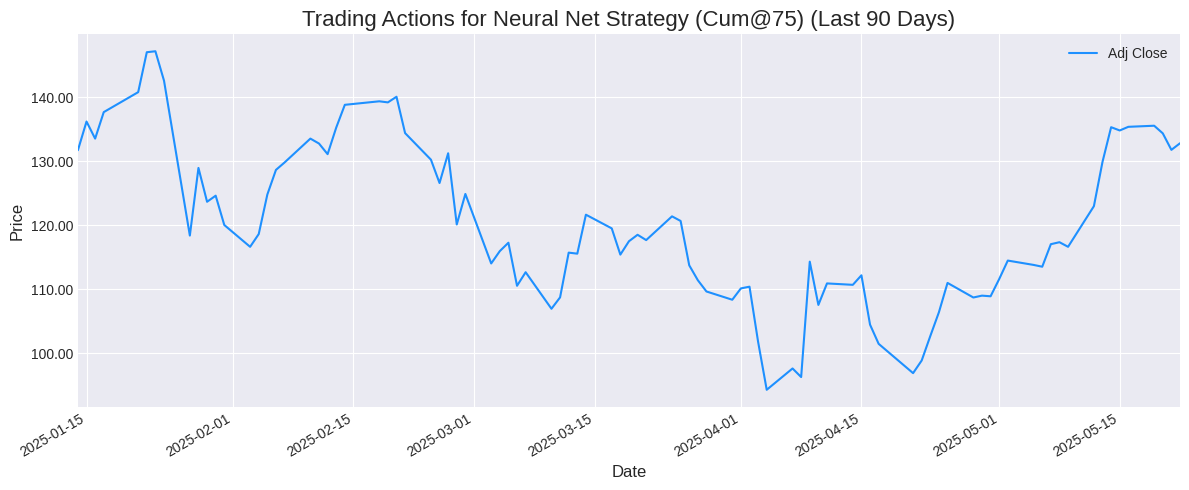

---------------------------------------------------------------------


--- Strategy: Neural Net Strategy (Cum@60) ---


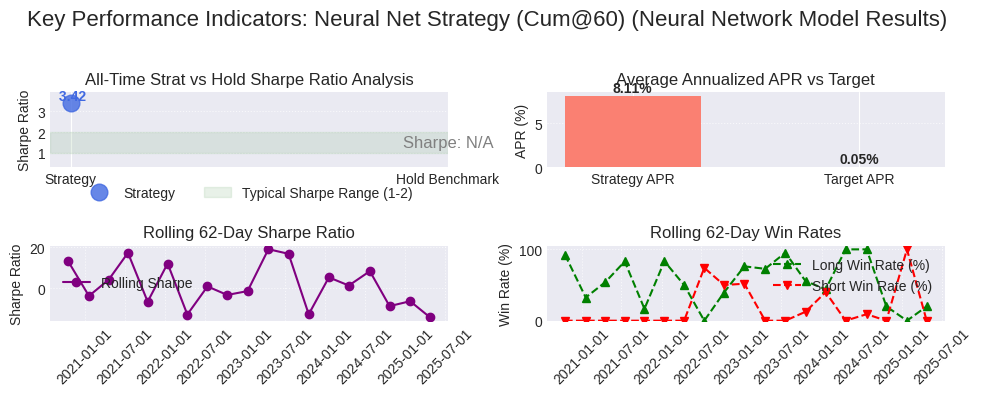

  Additional Stats:
    📈 Total Return: 44.86%
    Trades: 594
    Wins: 56.06%


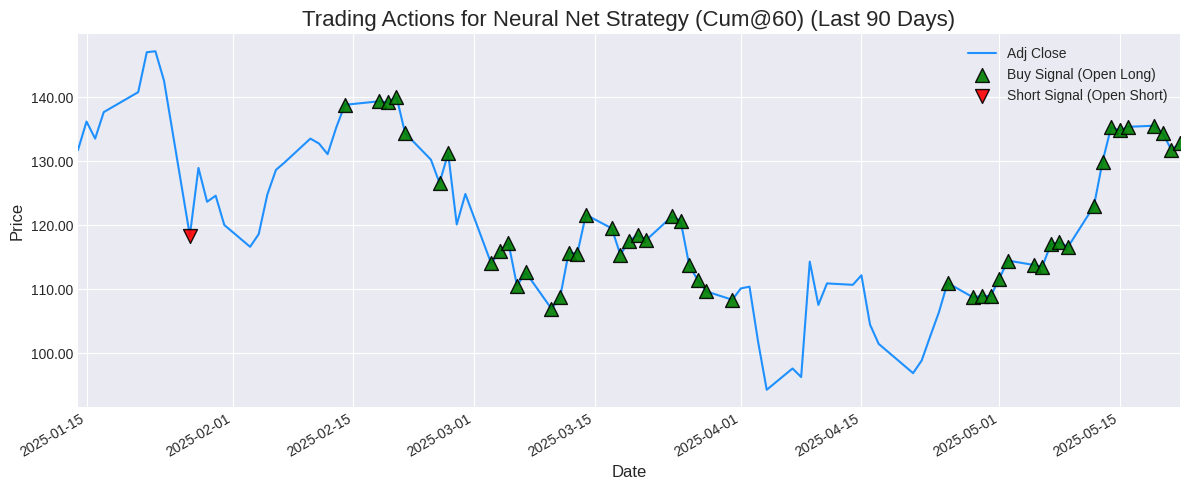

---------------------------------------------------------------------


--- Strategy: Perfect Foresight ---


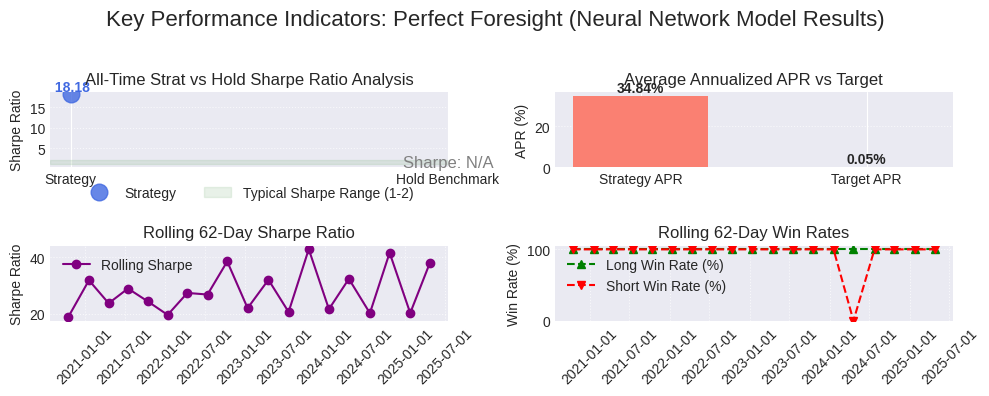

  Additional Stats:
    📈 Total Return: 314.10%
    Trades: 1118
    Wins: 100.00%


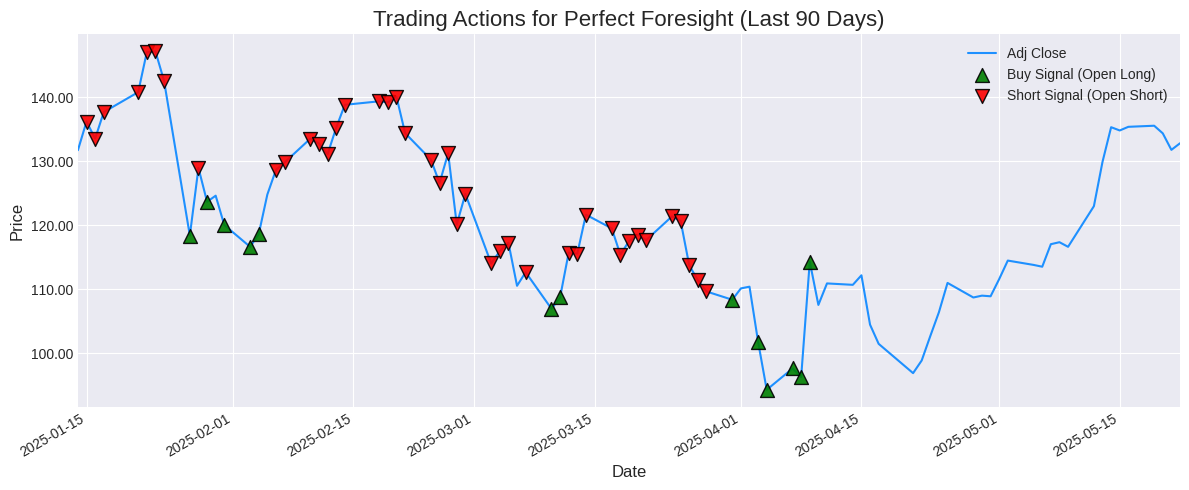

---------------------------------------------------------------------


In [337]:
##### RERUN BEST MODEL #####
reload_utils()
from utils.eval import run_trading_simulation
# --- Best Model(s) Params
nn_params = {"model_type": "lstm", "hidden": 1024, "dropout": 0.3,
            "activation": "relu", "batch_norm": True, "lr": 0.00005, "num_layers": 21 }

model, lr = get_nn_model(X_train.shape[1], output_dim=output_dim, **nn_params)

trained_nn, y_pred_nn, y_pred_proba_nn, y_preds_per_epoch_list = train_nn_model(
    model, X_train_nn, y_train, X_val_nn, y_val,
    epochs=NUM_EPOCH,
    lr=lr,
    task_type=task_type,
    eval_metric_name=eval_metric_name,
    eval_metric_fn=eval_metric_fn,
)

print("✅ Finished training neural net")
print("trained_nn Ready for evaluation.")

##### Getting Y_PRED for TEST SET #####
import torch
import torch.nn.functional as F
trained_nn.eval()  
X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    logits = trained_nn(X_test_tensor)
    y_pred_test_nn = torch.argmax(logits, dim=1).cpu().numpy()  # Predicted labels
    y_pred_proba_test_nn = F.softmax(logits, dim=1).cpu().numpy()  # Predicted probabilities
##### Getting Y_PRED for TEST SET #####

print("\n--- Running Trading Simulation for Neural Network Model ---")
portfolio_df_nn, metrics_nn, all_trade_actions_nn = run_trading_simulation(
    price_test_series=price_test_series,
    y_pred_proba_test=y_pred_proba_test_nn,
    cluster_mean_ev_mapping=cluster_mean_ev_mapping,
    model_classes_ordered=model_classes_ordered, 
    initial_portfolio_value=initial_portfolio_value,
    trade_size=trade_size,
    hold_apr=hold_apr,
    ev_profit_threshold=ev_profit_threshold,
    position_hold_days=position_hold_days,
    model_name="Neural Net Strategy",
    periods_per_year=periods_per_year)

model_display_name, metrics_dict, actions_dict = "Neural Network Model Results", metrics_nn, all_trade_actions_nn

benchmark_strategy_key = 'Hold Benchmark' 
benchmark_metrics = metrics_dict.get(benchmark_strategy_key, {})
print(f"\n\n{'='*70}")
print(f"📊 EVALUATING MODEL: {model_display_name}")
print(f"{'='*70}")
for strategy_name, trade_actions_list in actions_dict.items():
    if strategy_name == benchmark_strategy_key:
        continue
    strategy_specific_metrics = metrics_dict.get(strategy_name)
    if not strategy_specific_metrics:
        print(f"\nMetrics not found for strategy: '{strategy_name}' in {model_display_name}. Skipping.")
        continue

    print(f"\n\n--- Strategy: {strategy_name} ---")
    total_return_val = strategy_specific_metrics.get('Total Return (%)', np.nan)
    strategy_apr_pct_val = np.nan
    if num_years_in_series > 0 and not pd.isna(total_return_val) and total_return_val > -100:
        base_for_apr_calc = 1 + total_return_val / 100
        if base_for_apr_calc > 1e-9:
            strategy_apr_pct_val = (base_for_apr_calc**(1 / num_years_in_series) - 1) * 100
    
    strategy_specific_metrics['Calculated APR (%)'] = strategy_apr_pct_val

    visualize_strategy_kpis_versus_benchmarks(
        strategy_name=strategy_name,
        strategy_metrics=strategy_specific_metrics, 
        target_apr_pct_value=benchmark_apr_target_value,
        model_context_name=model_display_name,
        rolling_window_days=ROLLING_WINDOW_DAYS_PARAM 
    )

    strategy_sharpe_val = strategy_specific_metrics.get('Sharpe Ratio (Annualized)', np.nan)
    print(f"  Additional Stats:")
    if not pd.isna(total_return_val):
        print(f"    📈 Total Return: {total_return_val:.2f}%")
    else:
        print(f"    📈 Total Return: N/A")

    if 'Total Trades' in strategy_specific_metrics:
        print(f"    Trades: {strategy_specific_metrics['Total Trades']}")
        print(f"    Wins: {strategy_specific_metrics.get('Win Rate (%)', 0.0):.2f}%")
    else:
        print(f"    Trades: N/A")
    
    ###### Plotting Trade Actions ######
    plot_trading_actions(
        price_series=price_test_series,
        trade_actions=trade_actions_list,
        strategy_name=strategy_name,
        last_n_days=last_n_days_to_plot
    )
    print("-" * 69)



--- Strategy: Neural Net Strategy (Top-1) ---


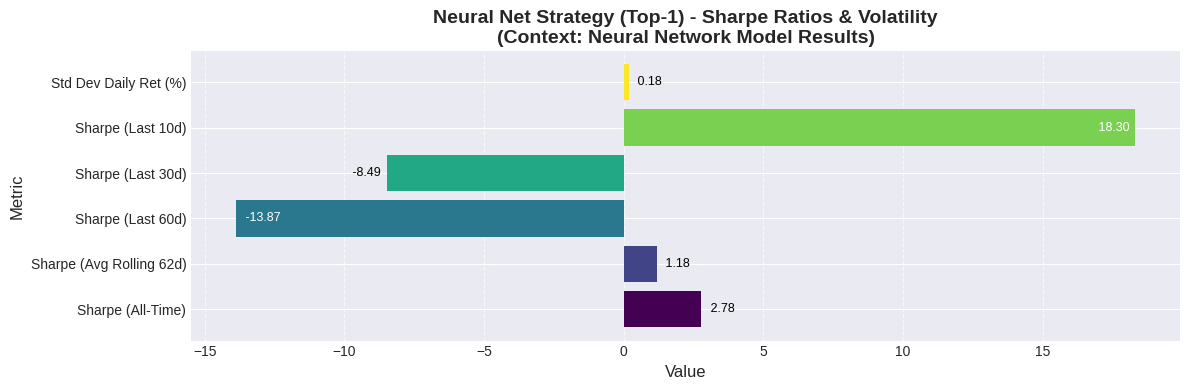

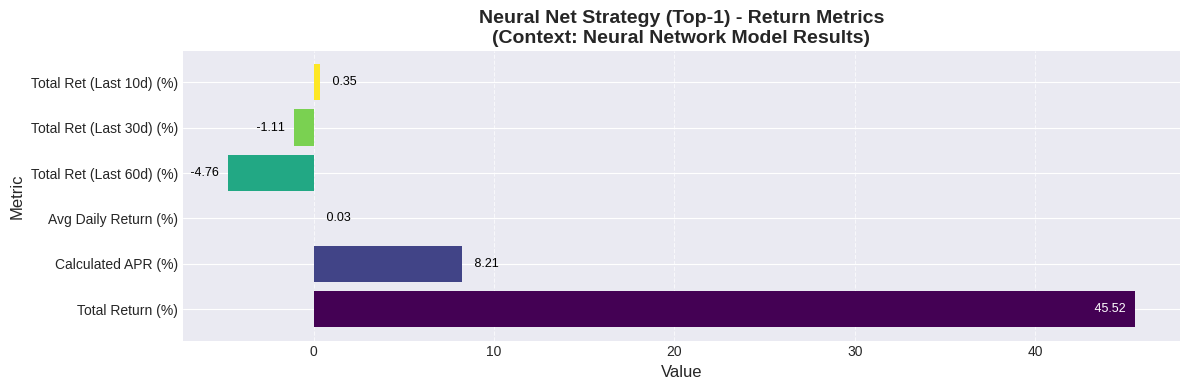

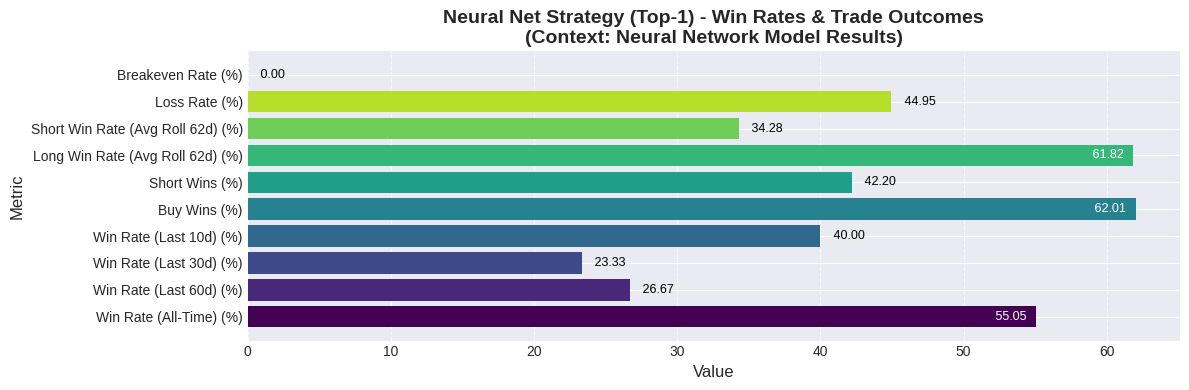

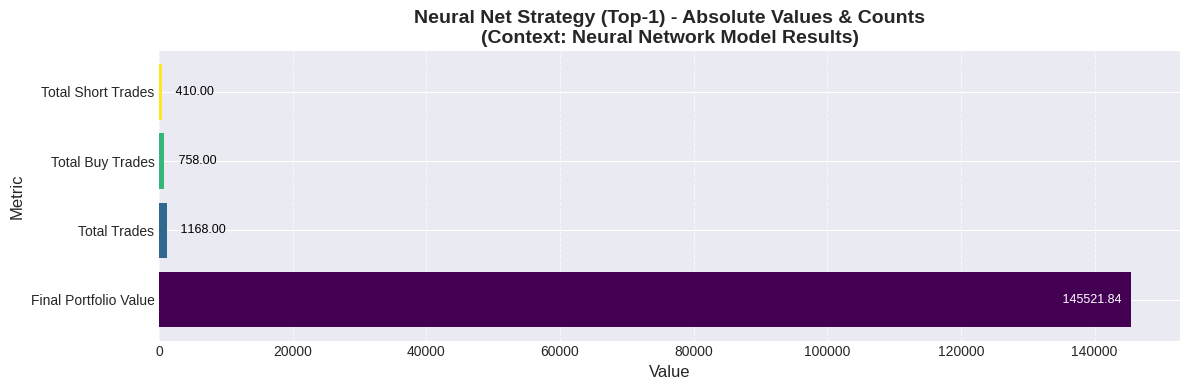

  Additional Stats (Text Summary):
    📈 Total Return: 45.52%
    🗓️ Calculated APR: 8.21%
    ⚖️ Sharpe Ratio (All-Time): 2.78
    Trades: 1168
    Wins: 55.05%


--- Strategy: Neural Net Strategy (Top-2 Consensus) ---


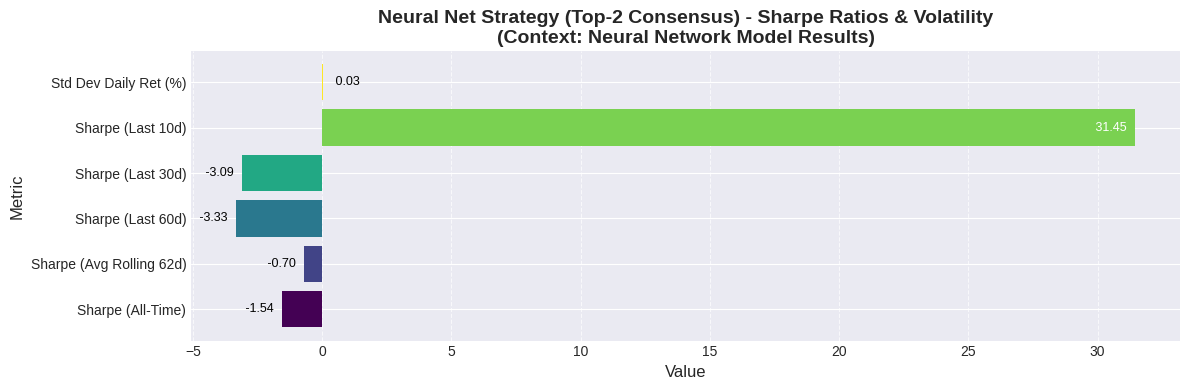

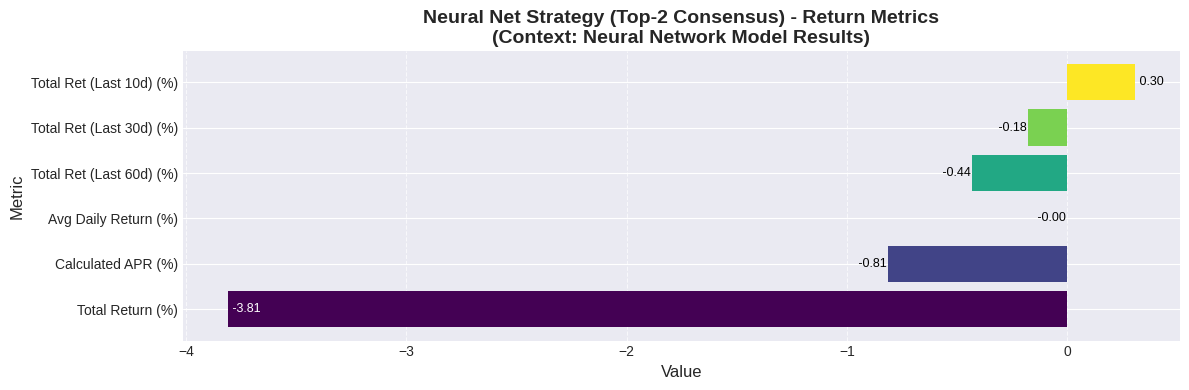

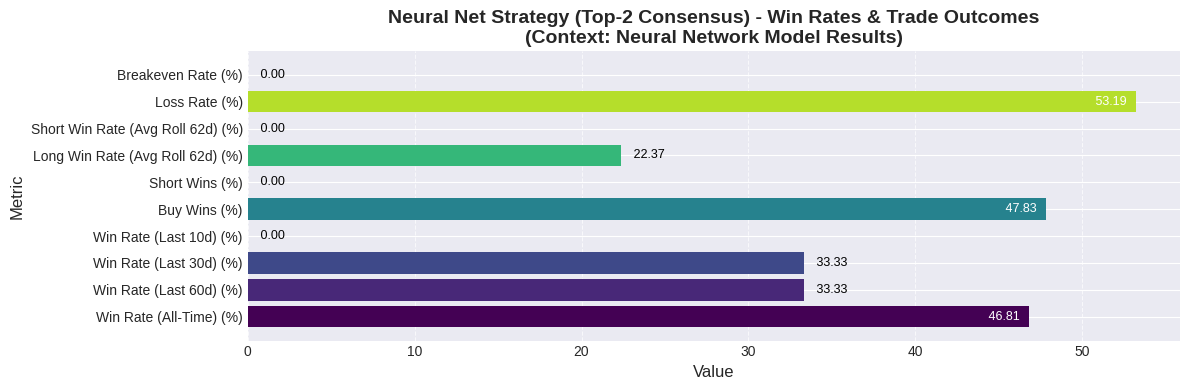

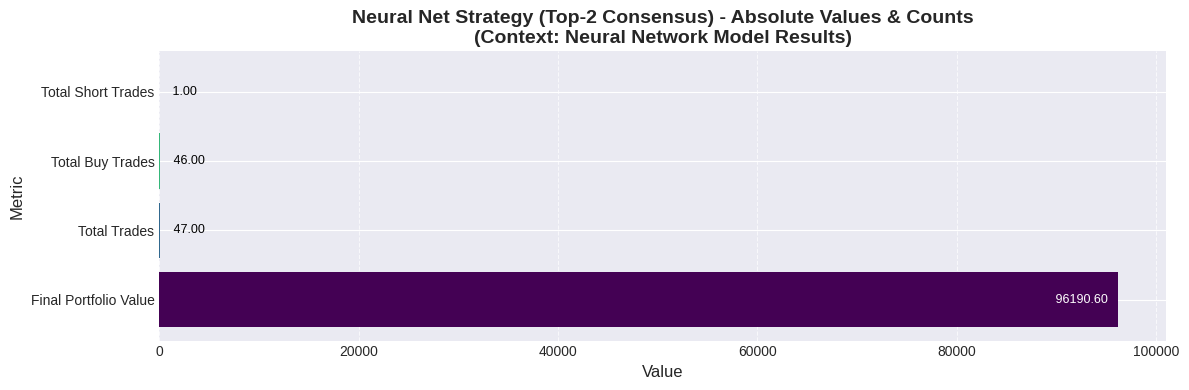

  Additional Stats (Text Summary):
    📈 Total Return: -3.81%
    🗓️ Calculated APR: -0.81%
    ⚖️ Sharpe Ratio (All-Time): -1.54
    Trades: 47
    Wins: 46.81%


--- Strategy: Neural Net Strategy (Cum@90) ---


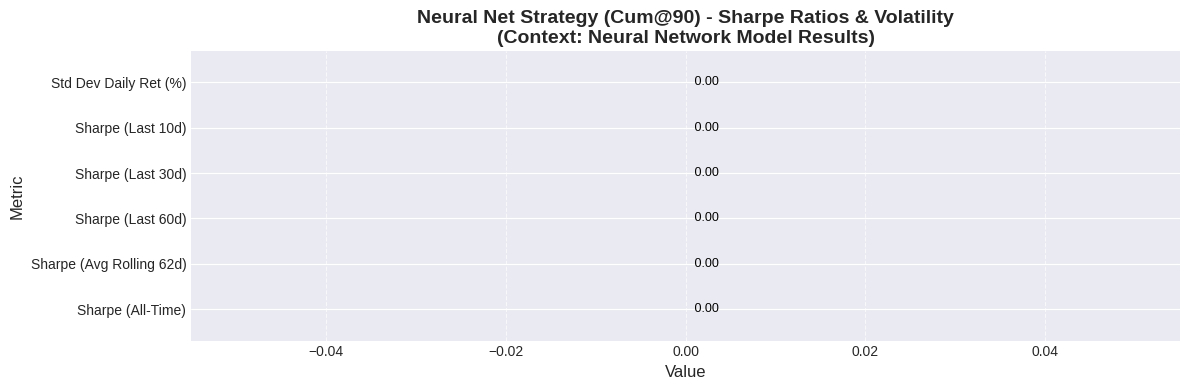

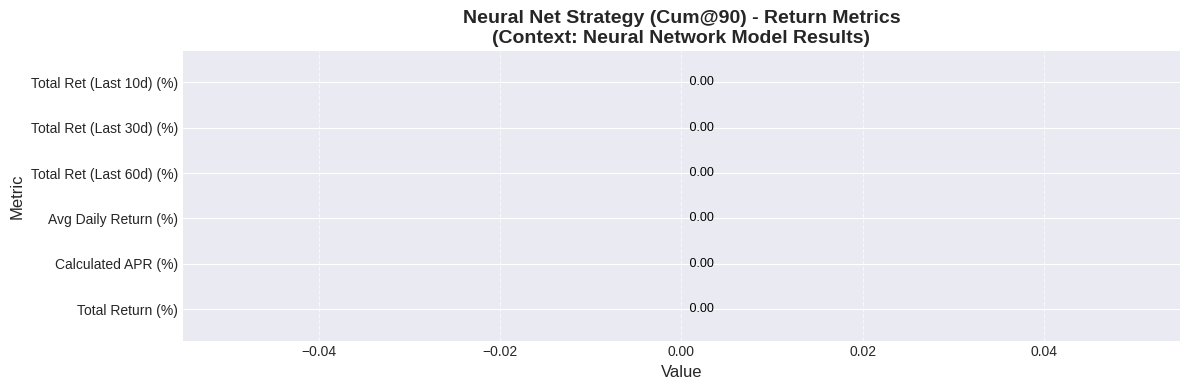

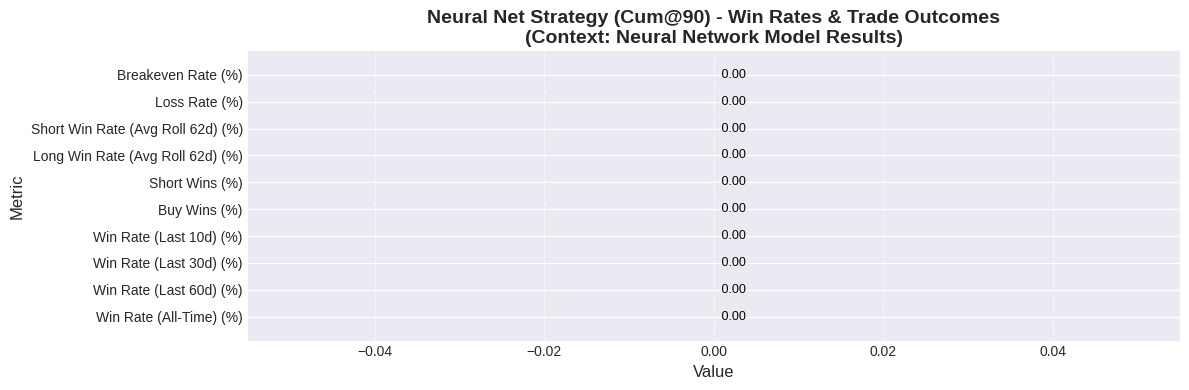

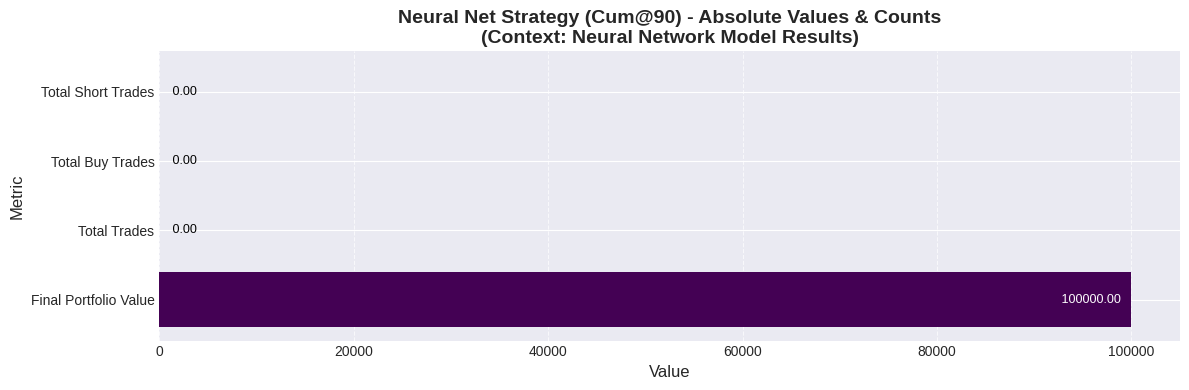

  Additional Stats (Text Summary):
    📈 Total Return: 0.00%
    🗓️ Calculated APR: 0.00%
    ⚖️ Sharpe Ratio (All-Time): 0.00
    Trades: 0
    Wins: 0.00%


--- Strategy: Neural Net Strategy (Cum@75) ---


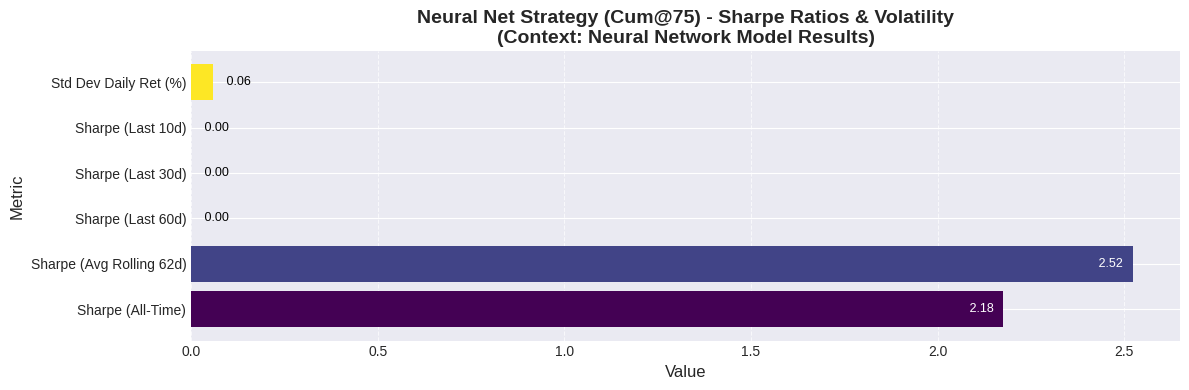

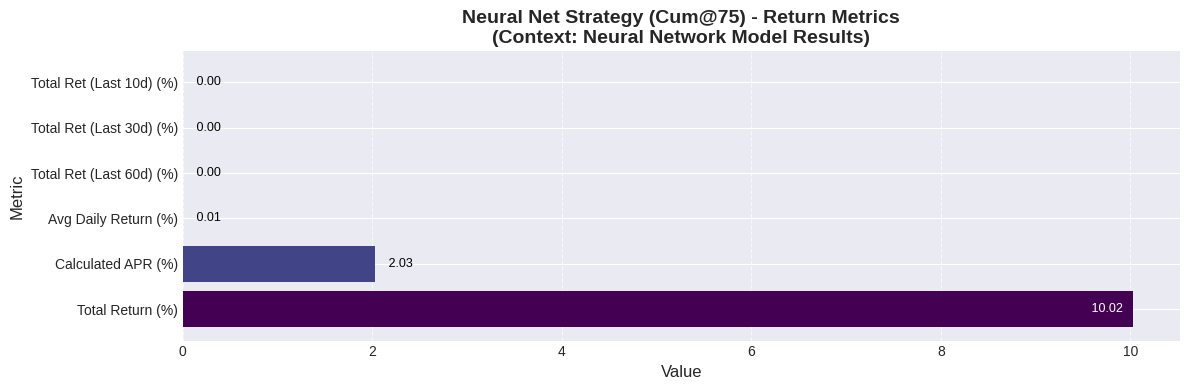

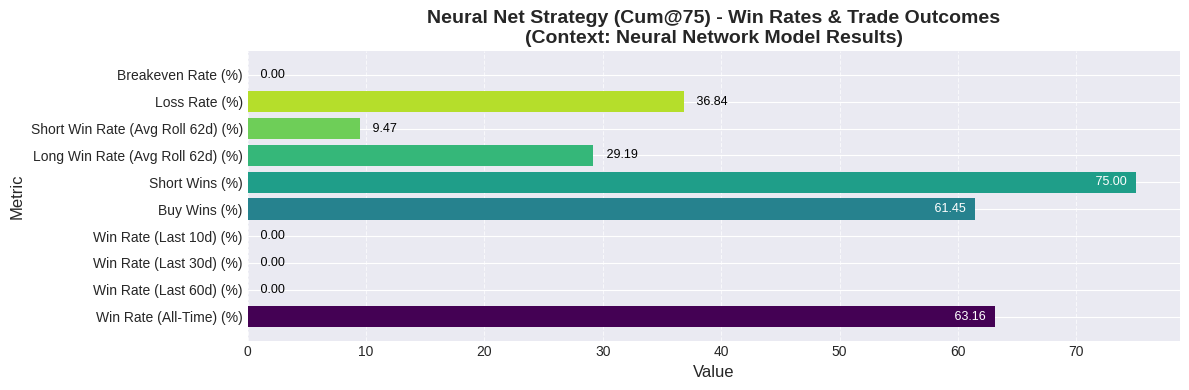

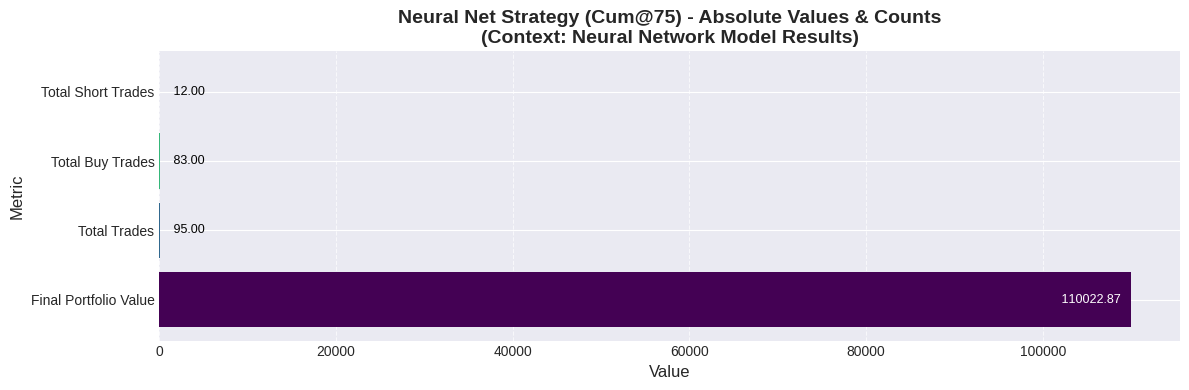

  Additional Stats (Text Summary):
    📈 Total Return: 10.02%
    🗓️ Calculated APR: 2.03%
    ⚖️ Sharpe Ratio (All-Time): 2.18
    Trades: 95
    Wins: 63.16%


--- Strategy: Neural Net Strategy (Cum@60) ---


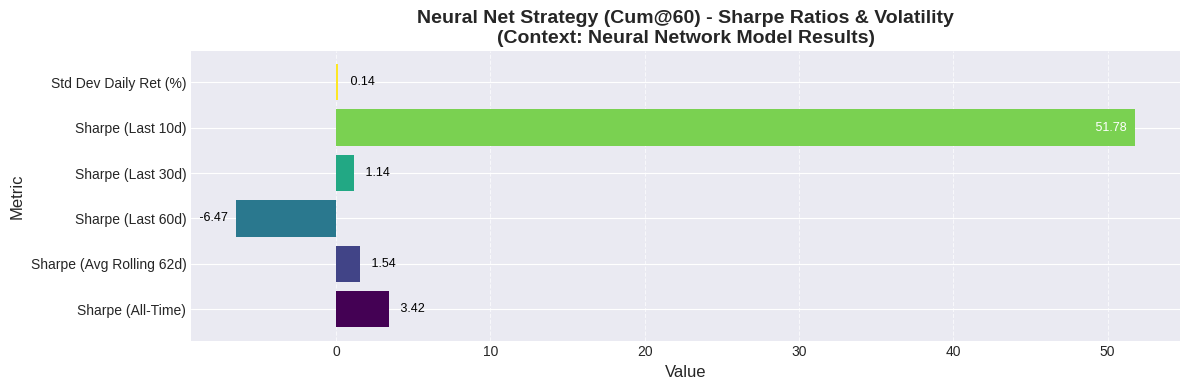

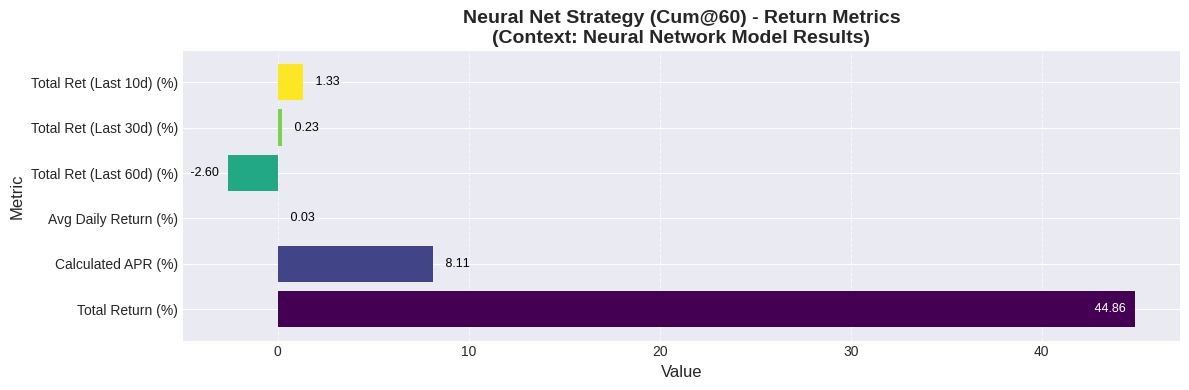

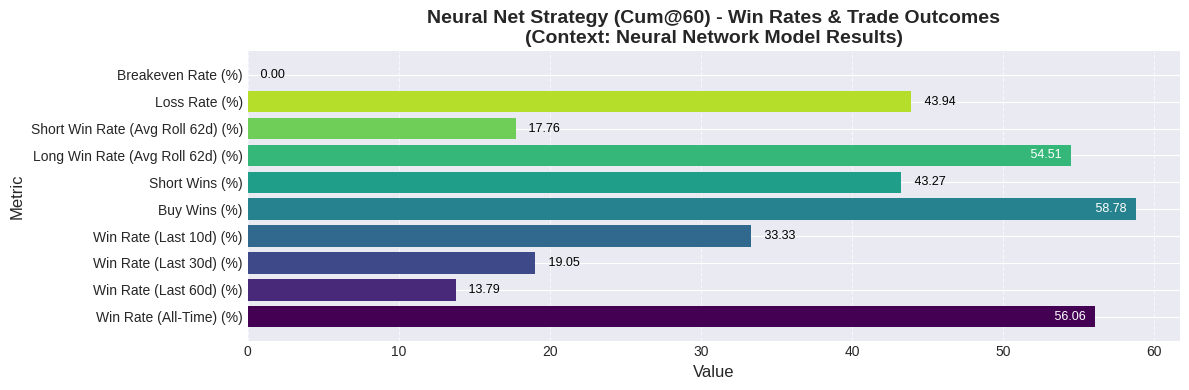

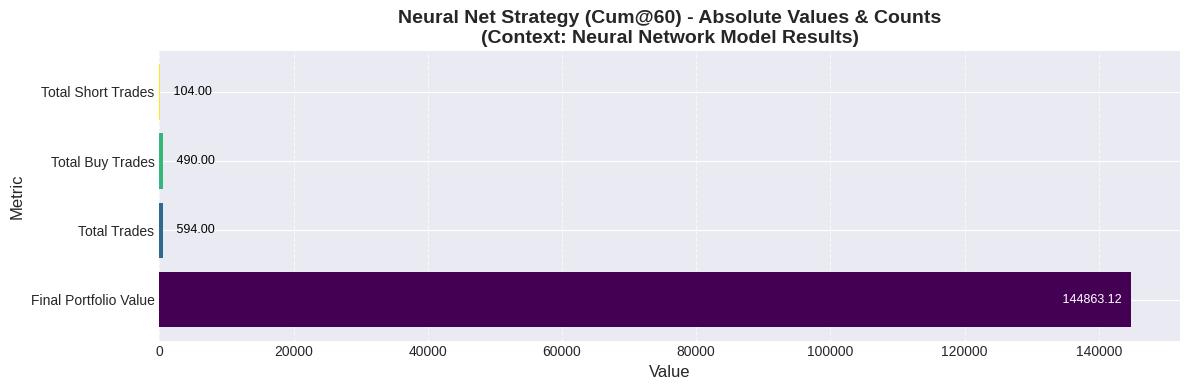

  Additional Stats (Text Summary):
    📈 Total Return: 44.86%
    🗓️ Calculated APR: 8.11%
    ⚖️ Sharpe Ratio (All-Time): 3.42
    Trades: 594
    Wins: 56.06%


--- Strategy: Perfect Foresight ---


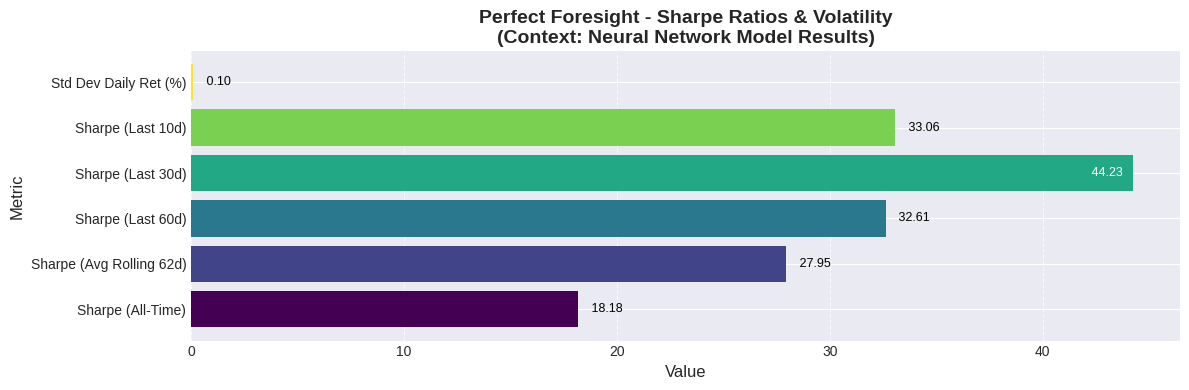

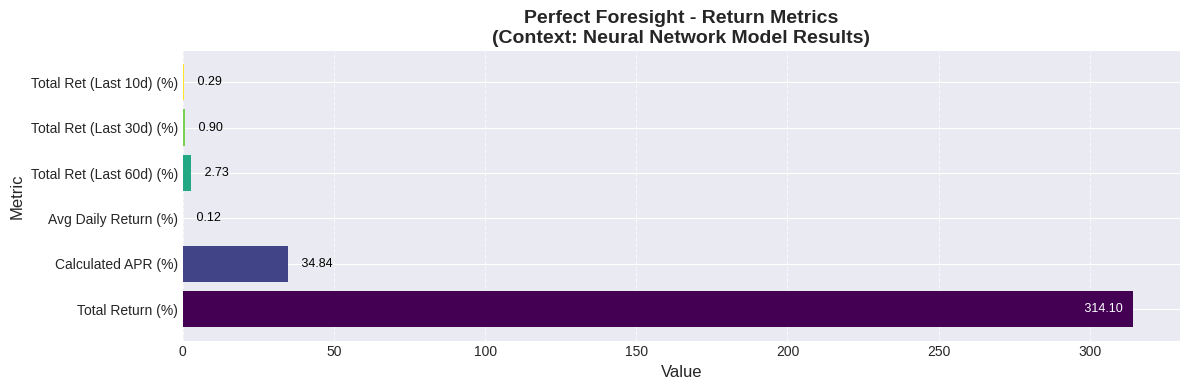

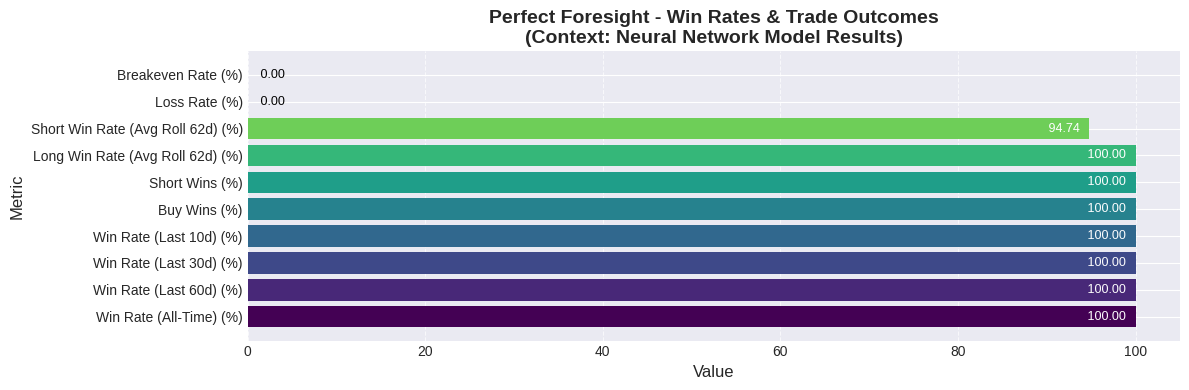

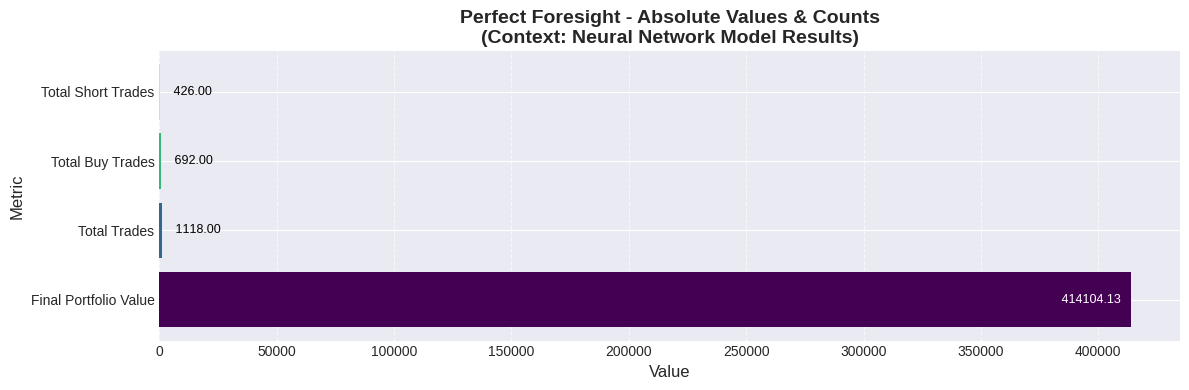

  Additional Stats (Text Summary):
    📈 Total Return: 314.10%
    🗓️ Calculated APR: 34.84%
    ⚖️ Sharpe Ratio (All-Time): 18.18
    Trades: 1118
    Wins: 100.00%


In [344]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure plot_horizontal_bar_chart function from the previous response is defined here
# def plot_horizontal_bar_chart(metrics_data, base_title, strategy_name, model_display_name):
# ... (definition from previous response) ...
# --- Helper function to plot horizontal bar charts (from previous response, ensure it's defined) ---
def plot_horizontal_bar_chart(metrics_data, base_title, strategy_name, model_display_name):
    """
    Generates a horizontal bar chart for the given metrics.
    """
    # Filter out NaN values and prepare data
    # The metrics_data is already {display_name: value}
    filtered_metrics = {k: v for k, v in metrics_data.items() if pd.notna(v)}

    if not filtered_metrics:
        print(f"No data to plot for '{base_title}' for strategy '{strategy_name}'. Skipping chart.")
        return

    names = list(filtered_metrics.keys())
    values = list(filtered_metrics.values())

    num_metrics = len(names)
    plt.figure(figsize=(12,4)) # Dynamic height

    bars = plt.barh(names, values, color=plt.cm.viridis(np.linspace(0, 1, num_metrics)))

    for i, bar in enumerate(bars):
        value = bar.get_width()
        # Position text based on value (positive/negative and magnitude)
        ha_align = 'left'
        text_x_pos = value + (plt.xlim()[1] * 0.01) # Small offset from bar end
        text_color = 'black'

        if value < 0:
            ha_align = 'right'
            text_x_pos = value - (plt.xlim()[1] * 0.01) # Small offset for negative bars

        # If bar is very long and positive, put text inside (white color)
        if value > 0 and value > (plt.xlim()[1] * 0.75): # Heuristic for "long bar"
            ha_align = 'right'
            text_x_pos = value - (plt.xlim()[1] * 0.01)
            text_color = 'white'
        elif value < 0 and abs(value) > (abs(plt.xlim()[0]) * 0.75): # Similar for long negative bars
            ha_align = 'left'
            text_x_pos = value + (plt.xlim()[1] * 0.01) # abs(plt.xlim()[0]) for neg range
            text_color = 'white'


        plt.text(text_x_pos, bar.get_y() + bar.get_height()/2.0, f' {value:.2f}',
                 va='center', ha=ha_align, fontsize=9, color=text_color, fontweight='medium')

    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Metric", fontsize=12)
    full_title = f"{strategy_name} - {base_title}"
    if model_display_name:
        full_title += f"\n(Context: {model_display_name})"
    plt.title(full_title, fontsize=14, fontweight='bold')

    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()


# --- Your existing loop, updated for revised plotting ---
# Assuming actions_dict, metrics_dict, benchmark_strategy_key, model_display_name,
# num_years_in_series, benchmark_apr_target_value, ROLLING_WINDOW_DAYS_PARAM are defined.

for strategy_name, trade_actions_list in actions_dict.items(): # Use your actual variable for actions_dict
    if strategy_name == benchmark_strategy_key:
        continue
    strategy_specific_metrics = metrics_dict.get(strategy_name) # Use your actual variable for metrics_dict
    if not strategy_specific_metrics:
        print(f"\nMetrics not found for strategy: '{strategy_name}' in {model_display_name}. Skipping.")
        continue

    print(f"\n\n--- Strategy: {strategy_name} ---")
    total_return_val = strategy_specific_metrics.get('Total Return (%)', np.nan)
    strategy_apr_pct_val = np.nan
    if num_years_in_series > 0 and not pd.isna(total_return_val) and total_return_val > -100:
        base_for_apr_calc = 1 + total_return_val / 100.0
        if base_for_apr_calc > 1e-9:
            strategy_apr_pct_val = (base_for_apr_calc**(1.0 / num_years_in_series) - 1) * 100.0
    
    strategy_specific_metrics['Calculated APR (%)'] = strategy_apr_pct_val

    # --- Revised Plotting Section ---

    # Helper function to prepare data for plotting based on a map
    def get_plot_data(metrics_map, source_metrics):
        plot_data = {}
        for display_name, original_key in metrics_map:
            if original_key in source_metrics and pd.notna(source_metrics[original_key]):
                plot_data[display_name] = source_metrics[original_key]
        return plot_data

    # 1. Sharpe Ratios & Volatility Chart
    sharpe_metrics_spec = [
        ("Sharpe (All-Time)", "Sharpe Ratio (Annualized, All-Time)"),
        (f"Sharpe (Avg Rolling {ROLLING_WINDOW_DAYS_PARAM}d)", f"Avg Rolling {ROLLING_WINDOW_DAYS_PARAM}-Day Sharpe"),
        ("Sharpe (Last 60d)", "sharpe_ratio_last_60_trading_days"),
        ("Sharpe (Last 30d)", "sharpe_ratio_last_30_trading_days"),
        ("Sharpe (Last 10d)", "sharpe_ratio_last_10_trading_days"),
        ("Std Dev Daily Ret (%)", "Std Dev Daily Return (%)")
    ]
    data_for_sharpe_plot = get_plot_data(sharpe_metrics_spec, strategy_specific_metrics)
    if data_for_sharpe_plot:
        plot_horizontal_bar_chart(data_for_sharpe_plot, "Sharpe Ratios & Volatility", strategy_name, model_display_name)

    # 2. Returns Chart
    returns_metrics_spec = [
        ("Total Return (%)", "Total Return (%)"),
        ("Calculated APR (%)", "Calculated APR (%)"),
        ("Avg Daily Return (%)", "Avg Daily Return (%)"),
        ("Total Ret (Last 60d) (%)", "running_total_returns_last_60_trading_days"),
        ("Total Ret (Last 30d) (%)", "running_total_returns_last_30_trading_days"),
        ("Total Ret (Last 10d) (%)", "running_total_returns_last_10_trading_days")
    ]
    data_for_returns_plot = get_plot_data(returns_metrics_spec, strategy_specific_metrics)
    if data_for_returns_plot:
        plot_horizontal_bar_chart(data_for_returns_plot, "Return Metrics", strategy_name, model_display_name)

    # 3. Win Rates & Trade Outcomes Chart
    win_rate_metrics_spec = [
        ("Win Rate (All-Time) (%)", "Win Rate (%)"),
        ("Win Rate (Last 60d) (%)", "win_rate_last_60_trading_days"),
        ("Win Rate (Last 30d) (%)", "win_rate_last_30_trading_days"),
        ("Win Rate (Last 10d) (%)", "win_rate_last_10_trading_days"),
        ("Buy Wins (%)", "Buy Wins (%)"),
        ("Short Wins (%)", "Short Wins (%)"),
        (f"Long Win Rate (Avg Roll {ROLLING_WINDOW_DAYS_PARAM}d) (%)", f"Avg Rolling {ROLLING_WINDOW_DAYS_PARAM}-Day Long Win Rate (%)"),
        (f"Short Win Rate (Avg Roll {ROLLING_WINDOW_DAYS_PARAM}d) (%)", f"Avg Rolling {ROLLING_WINDOW_DAYS_PARAM}-Day Short Win Rate (%)"),
        ("Loss Rate (%)", "Loss Rate (%)"),
        ("Breakeven Rate (%)", "Breakeven Rate (%)")
    ]
    data_for_win_rate_plot = get_plot_data(win_rate_metrics_spec, strategy_specific_metrics)
    if data_for_win_rate_plot:
        plot_horizontal_bar_chart(data_for_win_rate_plot, "Win Rates & Trade Outcomes", strategy_name, model_display_name)

    # 4. Absolute Values & Counts Chart
    counts_value_metrics_spec = [
        ("Final Portfolio Value", "Final Portfolio Value"),
        ("Total Trades", "Total Trades"),
        ("Total Buy Trades", "Total Buy Trades"),
        ("Total Short Trades", "Total Short Trades")
    ]
    data_for_counts_plot = get_plot_data(counts_value_metrics_spec, strategy_specific_metrics)
    if data_for_counts_plot:
        plot_horizontal_bar_chart(data_for_counts_plot, "Absolute Values & Counts", strategy_name, model_display_name)


    # --- Existing visualization call (can be kept or removed based on your needs) ---
    # visualize_strategy_kpis_versus_benchmarks(
    #     strategy_name=strategy_name,
    #     strategy_metrics=strategy_specific_metrics,
    #     target_apr_pct_value=benchmark_apr_target_value,
    #     model_context_name=model_display_name,
    #     rolling_window_days=ROLLING_WINDOW_DAYS_PARAM
    # )

    # --- Existing print statements (can be kept or removed) ---
    strategy_sharpe_val = strategy_specific_metrics.get('Sharpe Ratio (Annualized, All-Time)', np.nan)
    print(f"  Additional Stats (Text Summary):")
    if not pd.isna(total_return_val):
        print(f"    📈 Total Return: {total_return_val:.2f}%")
    else:
        print(f"    📈 Total Return: N/A")
    
    if not pd.isna(strategy_apr_pct_val):
        print(f"    🗓️ Calculated APR: {strategy_apr_pct_val:.2f}%")
    else:
        print(f"    🗓️ Calculated APR: N/A")

    if not pd.isna(strategy_sharpe_val):
        print(f"    ⚖️ Sharpe Ratio (All-Time): {strategy_sharpe_val:.2f}")
    else:
        print(f"    ⚖️ Sharpe Ratio (All-Time): N/A")

    if 'Total Trades' in strategy_specific_metrics and pd.notna(strategy_specific_metrics['Total Trades']):
        print(f"    Trades: {strategy_specific_metrics['Total Trades']}")
        if 'Win Rate (%)' in strategy_specific_metrics and pd.notna(strategy_specific_metrics['Win Rate (%)']):
             print(f"    Wins: {strategy_specific_metrics.get('Win Rate (%)', 0.0):.2f}%")
        else:
             print(f"    Wins: N/A")
    else:
        print(f"    Trades: N/A")
        print(f"    Wins: N/A")